# Machine Learning Algorithm SVM

In this notebook, the following happens: Data is loaded. Features are visualized. A Model is trained. Model performance is evaluated.

The following things can be optimized:
- Feature columns
- Scaler to use
- Algorithm itself

## Parameter

In [1]:
#Define a config file here to have a static start. If nothing is 
#config_file_path = "config_5dTrend_Training.json"
config_file_path = None

In [2]:
#Default notebook parameters as dict
default_config = dict()
default_config['use_training_settings'] = True
default_config['dataset_name'] = "omxs30_train"
default_config['source_path'] = '01_Source/^OMX_1986-2018.csv'
default_config['class_name'] = "LongTrend"
#Binarize labels
default_config['binarize_labels'] = True
default_config['class_number'] = 1   #Class number in outcomes, which shall be the "1" class
default_config['binary_1_label'] = "Pos. Trend"
default_config['binary_0_label'] = "Neg. Trend"

In [3]:
import joblib
import json

if config_file_path is None:
    #Use file default or set config
    #Use default
    conf = default_config
    #config = default_test_config
    
else:
    #A config path was given
    #Load config from path
    with open(config_file_path, 'r') as fp:
        conf = json.load(fp)
        
    print("Loaded notebook parameters from config file: ", config_file_path)
print("Loaded config: ",json.dumps(conf, indent=2)) 

Loaded config:  {
  "use_training_settings": true,
  "dataset_name": "omxs30_train",
  "source_path": "01_Source/^OMX_1986-2018.csv",
  "class_name": "LongTrend",
  "binarize_labels": true,
  "class_number": 1,
  "binary_1_label": "Pos. Trend",
  "binary_0_label": "Neg. Trend"
}


In [4]:
# Constants for all notebooks in the Machine Learning Toolbox

print("Directories")
training_data_directory = "02_Training_Data"
target_directory = training_data_directory
print("Training data directory: ", training_data_directory)

#training_image_save_directory = training_data_directory + '/images'
#print("Training data image save directory: ", training_image_save_directory)

#test_data_directory = "03_Test_Prepared_Data"
#print("Test data directory: ", test_data_directory)

#test_image_save_directory = test_data_directory + '/images'
#print("Training data image save directory: ", test_image_save_directory)

model_directory = "04_Model"
print("Model directory: ", model_directory)

Directories
Training data directory:  02_Training_Data
Model directory:  04_Model


In [5]:
# Generating filenames for saving the files
#features_filename = target_directory + "/" + conf['dataset_name'] + "_features" + ".csv"
model_features_filename = target_directory + "/" + conf['dataset_name'] + "_" + conf['class_name'] + "_features_for_model" + ".csv"
#outcomes_filename = target_directory + "/" + conf['dataset_name'] + "_outcomes" + ".csv"
model_outcomes_filename = target_directory + "/" + conf['dataset_name'] + "_" + conf['class_name'] + "_outcomes_for_model" + ".csv"
#labels_filename = target_directory + "/" + conf['dataset_name'] + "_labels" + ".csv"
source_filename = target_directory + "/" + conf['dataset_name'] + "_source" + ".csv"
#Modified labels
model_labels_filename = target_directory + "/" + conf['dataset_name'] + "_" + conf['class_name'] + "_labels_for_model" + ".csv"
#Columns for feature selection
selected_feature_columns_filename = target_directory + "/" + conf['dataset_name'] + "_" + conf['class_name'] + "_selected_feature_columns.csv"

#Model specifics
svm_model_filename = model_directory + "/" + conf['dataset_name'] + "_" + conf['class_name'] + "_svm_model" + ".sav"
svm_external_parameters_filename = model_directory + "/" + conf['dataset_name'] + "_" + conf['class_name'] + "_svm_model_ext_parameters" + ".json"
svm_default_hyper_parameters_filename = model_directory + "/" + conf['dataset_name'] + "_" + conf['class_name'] + "_svm_model_hyper_parameters" + ".json"

print("=== Paths ===")
#print("Input Features: ", features_filename)
print("Prepared Features: ", model_features_filename)
#print("Input Outcomes: ", outcomes_filename)
print("Prepared Outcome: ", model_outcomes_filename)
#print("Labels: ", labels_filename)
print("Original source: ", source_filename)
print("Labels for the model: ", model_labels_filename)
print("Selected feature columns: ", selected_feature_columns_filename)

print("Model to save/load: ", svm_model_filename)
print("External parameters to load: ", svm_external_parameters_filename)
print("Default hyper parameters to load: ", svm_default_hyper_parameters_filename)

=== Paths ===
Prepared Features:  02_Training_Data/omxs30_train_LongTrend_features_for_model.csv
Prepared Outcome:  02_Training_Data/omxs30_train_LongTrend_outcomes_for_model.csv
Original source:  02_Training_Data/omxs30_train_source.csv
Labels for the model:  02_Training_Data/omxs30_train_LongTrend_labels_for_model.csv
Selected feature columns:  02_Training_Data/omxs30_train_LongTrend_selected_feature_columns.csv
Model to save/load:  04_Model/omxs30_train_LongTrend_svm_model.sav
External parameters to load:  04_Model/omxs30_train_LongTrend_svm_model_ext_parameters.json
Default hyper parameters to load:  04_Model/omxs30_train_LongTrend_svm_model_hyper_parameters.json


## Load Training and Test Data

In [6]:
#Imports
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as m

import DataSupportFunctions as sup
import DatavisualizationFunctions as vis

from sklearn.model_selection import train_test_split

#Global settings
np.set_printoptions(precision=3)

#Suppress print out in scientific notiation
np.set_printoptions(suppress=True)

#Load skip cell kernel extension
#Source: https://stackoverflow.com/questions/26494747/simple-way-to-choose-which-cells-to-run-in-ipython-notebook-during-run-all
#%%skip True  #skips cell
#%%skip False #won't skip
#should_skip = True
#%%skip $should_skip
%load_ext skip_kernel_extension

In [7]:
#=== Load features from X ===#
df_X = pd.read_csv(model_features_filename, delimiter=';').set_index('id')
print("Loaded feature names for X={}".format(df_X.columns))
print("X. Shape={}".format(df_X.shape))
print("Indexes of X={}".format(df_X.index.shape))

#=== Load y values ===#
df_y = pd.read_csv(model_outcomes_filename, delimiter=';').set_index('id')
y = df_y.values.flatten()
print("y. Shape={}".format(y.shape))

#=== Load classes ===#
df_y_classes = pd.read_csv(model_labels_filename, delimiter=';', header=None)
y_classes_source = sup.inverse_dict(df_y_classes.set_index(df_y_classes.columns[0]).to_dict()[1])
print("Loaded classes into dictionary: {}".format(y_classes_source))

#=== Load list of feature columns ===#
df_feature_columns = pd.read_csv(selected_feature_columns_filename, delimiter=';')
print("Selected features: {}".format(selected_feature_columns_filename))
display(df_feature_columns)

Loaded feature names for X=Index(['NormKurs5', 'NormKurs20', 'NormKurs50', 'NormKurs100', 'NormKurs200',
       'NumberRise5', 'NumberRise20', 'NumberRise50', 'NumberRise100',
       'NumberRise200',
       ...
       'month_year__9', 'month_year__10', 'month_year__11', 'month_year__12',
       'week_month__1', 'week_month__2', 'week_month__3', 'week_month__4',
       'week_month__5', 'week_month__6'],
      dtype='object', length=127)
X. Shape=(7653, 127)
Indexes of X=(7653,)
y. Shape=(7653,)
Loaded classes into dictionary: {0: 'Neg. Trend', 1: 'Pos. Trend'}
Selected features: 02_Training_Data/omxs30_train_LongTrend_selected_feature_columns.csv


,Lasso,Tree,Backward_Elimination,RecursiveTop32,RecursiveTop64,RecursiveTop96,Manual,All
0,MA150Norm,Stoch_Sk211414,NormKurs20,MA325Norm,MA325Norm,MA325Norm,MA100Norm,NormKurs5
1,NumberRise50,RSI_20,NormKurs50,MA400Norm,MA400Norm,MA400Norm,MA125Norm,NormKurs20
2,NormKurs20,MA75Norm,NormKurs100,MA175Norm,MA175Norm,MA175Norm,MA150Norm,NormKurs50
3,NumberRise20,NumberRise50,NormKurs200,NumberRise200,NumberRise200,NumberRise200,MA175Norm,NormKurs100
4,MACD_12_26_9Diff,NumberRise200,NumberRise5,MA125Norm,MA125Norm,MA125Norm,MA200Norm,NormKurs200
...,...,...,...,...,...,...,...,...
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__2
123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__3
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__4
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__5


In [8]:
# Get class information and remove unused classes
a, b = np.unique(y, return_counts=True)
vfunc = np.vectorize(lambda x:y_classes_source[x]) #Vectorize a function to process a whole array
print("For the classes with int {} and names {} are the counts {}".format(a, vfunc(a), b))

y_classes = {}

for i in a:
    y_classes[i] = y_classes_source[i]
    
print("The following classes remain", y_classes)

#Check if y is binarized
if len(y_classes) == 2 and np.max(list(y_classes.keys())) == 1:
    is_multiclass = False
    print("Classes are binarized, 2 classes.")
else:
    is_multiclass = True
    print("Classes are not binarized, {} classes with values {}. For a binarized class, the values should be [0, 1].".format(len(y_classes), list(y_classes.keys())))

For the classes with int [0 1] and names ['Neg. Trend' 'Pos. Trend'] are the counts [2504 5149]
The following classes remain {0: 'Neg. Trend', 1: 'Pos. Trend'}
Classes are binarized, 2 classes.


## Split Data into Train and Cross Validation Test Data

In [9]:
#print("No train/test splitting necessary")
from sklearn.model_selection import train_test_split

#Split test and training sets
### WARNING: Data is not shuffled for this example ####
#X_train, X_test, y_train, y_test = train_test_split(df_X, y, random_state=0, test_size=0.2, shuffle=True, stratify = y) #cross validation size 20
X_train, X_test, y_train, y_test = train_test_split(df_X, y, random_state=0, test_size=0.2, shuffle=False) #cross validation size 20
print("Total number of samples: {}. X_train: {}, X_test: {}, y_train: {}, y_test: {}".format(df_X.shape[0], X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Total number of samples: 7653. X_train: (6122, 127), X_test: (1531, 127), y_train: (6122,), y_test: (1531,)


## Handle Missing Values in the Training Data Manually

In the hyper parameter optimization, automatic methods for handling missing data are tested.

In [10]:
#Remove rows with too many missing values
#print("Dataset size: ", df_dig.shape)
#Drop all rows with > 50% missing values
#df_compl = df_dig[np.sum(df_dig.iloc[:].isna(), axis=1)/len(df_dig.columns[0:-1])<0.5]
#print("Dataset size: ", df_compl.shape)

In [11]:
#Use linear regression or knn to set the feature values

In [12]:
#replace NaNs with impute, mean
#meansModelFromTrainingData = df_compl.mean()

#Replace all NaN with their column means
#df_compl.fillna(meansModelFromTrainingData, inplace=True)

print("Missing data model")
print(X_train.isna().sum())

Missing data model
NormKurs5        0
NormKurs20       0
NormKurs50       0
NormKurs100      0
NormKurs200      0
                ..
week_month__2    0
week_month__3    0
week_month__4    0
week_month__5    0
week_month__6    0
Length: 127, dtype: int64


In [13]:
#Save the missing data model as a file for the test set
#filename = filedataresultdirectoy + "/" + filenameprefix + "_missing_value_model_.csv"
#meansModelFromTrainingData.to_csv(missingValueModelPath, sep=';', index=True, header=False)
#print("Saved the missing data model with mean values of the columns to " + missingValueModelPath)

# Baseline Prediction
to see if predicted values are significant. The following classifiers are used:
- Majority class prediction
- Stratified class prediction

In [14]:
#Create scorers to be used in GridSearchCV and RandomizedSearchCV

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix

#average_method = 'micro' #Add all FP1..FPn together and create Precision or recall from them. It is like weighted classes
average_method = 'macro' #Calculate Precision1...Precisionn and Recall1...Recalln separately and average. It is good to increase
#the weight of smaller classes

scorers = {
    'precision_score': make_scorer(precision_score, average=average_method),
    'recall_score': make_scorer(recall_score, average=average_method),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score, average=average_method)
}

refit_scorer_name = 'f1_score'

#### Most Frequent
Implement a dummy classifier for the most frequent value

In [15]:
# Get class information
a, b = np.unique(y_train, return_counts=True)
vfunc = np.vectorize(lambda x:y_classes[x]) #Vectorize a function to process a whole array
print("For the classes with int {} and names {} are the counts {}".format(a, vfunc(a), b))

For the classes with int [0 1] and names ['Neg. Trend' 'Pos. Trend'] are the counts [2046 4076]


In [16]:
#Dummy Classifier Most Frequent
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
from sklearn.model_selection import cross_val_score

# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train.values, y_train)

#X_converted, y_converted = check_X_y(X=X_cross, y=y_cross)

# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_dummy_pred = dummy_majority.predict(X_test.values)

confusion = confusion_matrix(y_test, y_dummy_pred)

class_names = np.array(list(y_classes.keys()))

print("Accuracy of the most frequent predictor on training data: " + str(dummy_majority.score(X_train, y_train)))
print('Most frequent class (dummy classifier)\n', confusion)
print('F1 score={}'.format(f1_score(y_test, y_dummy_pred, average=average_method)))

Accuracy of the most frequent predictor on training data: 0.6657954916693891
Most frequent class (dummy classifier)
 [[   0  458]
 [   0 1073]]
F1 score=0.4120583717357911


#### Stratified Class Prediction Results

In [17]:
#Dummy classifier for stratified results, i.e. according to class distribution
np.random.seed(0)
dummy_majority = DummyClassifier(strategy = 'stratified').fit(X_train.values, y_train)
y_dummy_pred = dummy_majority.predict(X_test.values)

confusion = confusion_matrix(y_test, y_dummy_pred)

print("Accuracy of the stratified (generates predictions by respecting the training set’s class distribution) predictor on training data: " + str(dummy_majority.score(X_train, y_train)))
print('Stratified classes (dummy classifier)\n', confusion)
print('F1 score={}'.format(f1_score(y_test, y_dummy_pred, average=average_method)))

Accuracy of the stratified (generates predictions by respecting the training set’s class distribution) predictor on training data: 0.5586409670042469
Stratified classes (dummy classifier)
 [[171 287]
 [356 717]]
F1 score=0.5188134976012356


## Training Duration Estimation
Purposes:
1. Check how well the algorithm scale with much data
2. Check how much data is necessary to perform a gridsearch

In [18]:
#Set test range
test_range = list(range(100, 6500+1, 500))
test_range

[100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600, 6100]

In [19]:
#Estimate training duration
%matplotlib inline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import time
import random

run_training_estimation = False

if run_training_estimation==True:
    np.random.seed(0)
    #SVM scaling: O(n_samples^2 * n_features). 5000->40s, 500000 -> 40*10000=400000

    examples = test_range
    durations=[]
    scores=[]
    for i in examples:
        #Set the number of samples fr
        numberOfSamples = i

        if X_train.shape[0] > numberOfSamples:
            _, X_train_subset, _, y_train_subset = train_test_split(X_train, y_train, random_state=0, test_size=numberOfSamples/X_train.shape[0], shuffle=True, stratify = y_train)
            #X_train_index_subset = random.sample(list(range(0, X_train_shuffled.shape[0], 1)), k=numberOfSamples)
            #print("Cutting the data to size ", numberOfSamples)
        else:
            X_train_subset = X_train #list(range(0, X_train.shape[0], 1))
            y_train_subset = y_train
            #print("No change of data")

        t=time.time()
        local_time = time.ctime(t)
        #print("Start training the SVM at ", local_time)
        optclf = svm.SVC(probability=True, C=1, gamma=0.01, kernel='rbf', verbose=False)
        optclf.fit(X_train_subset.values, y_train_subset)
        elapsed = time.time() - t
        durations.append(elapsed)
        y_test_pred = optclf.predict(X_test)
        score = f1_score(y_test, y_test_pred, average=average_method) #Micro, consider skewed data for the whole dataset
        scores.append(score)
        print("Training of {} examples; duration {}s; f1-score={}".format(i, np.round(elapsed, 3), np.round(score, 3)))

    plt.figure()
    plt.plot(examples, durations)
    plt.xlabel('Number of training examples')
    plt.ylabel('Duration [s]')
    plt.title("Training Duration")

    plt.figure()
    plt.plot(examples, scores)
    plt.xlabel('Number of training examples')
    plt.ylabel('F1-Score on cross validation set (=the rest). Size={}'.format(X_test.shape[0]))
    plt.title("F1 Score Improvement With More Data")

# Hyper Parameter Optimization
gridsearch, random grid search, hyperopt, automl. Things to optimize:
- What type of normalization
- Feature selection possibilites
- Different algorithms, like knn, svm, random forest
- For each algorithm, the parameters

## Grid Search
Do the following steps
1. Select how much data shall be used in the searches. Maybe all data is not necessary
2. Perform a broad gridsearch to find the optimal parameter range
3. Perform a narrow random search within the best areas of the gridsearch to find optimal values

#### Custom Estimators
Here, custom estimators are put, which are added to the search pipe.

In [20]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
# Column extractor object

class Nosampler(BaseEstimator, TransformerMixin):
    '''The nosampler class do not do any type of sampling. It shall be used to compare with common over, under and 
    combined samplers'''

    #def __init__(self):
        #self.cols = cols

    def transform(self, X):
        return X

    def fit(self, X, y=None):
        return self

#res = Nosampler().transform(X_train.values)
#display(res)
#X_train.values

In [21]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
# Column extractor object

class ColumnExtractor(BaseEstimator, TransformerMixin):
    '''Column extractor method to extract selected columns from a list. This is used as a feature selector. Source
    https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline,
    http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/.'''

    def __init__(self, cols=[0]):
        self.cols = cols

    def transform(self, X):
        col_list = []
        if self.cols is not None:
            return X[:,self.cols]
        else:
            return X
        #for c in self.cols:
        #    col_list.append(X[:, c:c+1])
        #return np.concatenate(col_list, axis=1)
        #return X[self.cols].values

    def fit(self, X, y=None):
        return self

#X_train[['MA2Norm', 'MA5Norm']]
#colList = [0, 1]
#col = ColumnExtractor(cols=colList).transform(X_train.values)
#col

In [22]:
def getListFromColumn(df, df_source, col_number):
    col_names = list(df[df.columns[col_number]].dropna().values)
    col_index = [i for i, col in enumerate(df_source) if col in col_names]
    return col_index

selected_features = [getListFromColumn(df_feature_columns, df_X, i) for i in range(0, df_feature_columns.shape[1])]
feature_dict = dict(zip(df_feature_columns.columns, selected_features))
#display(feature_dict)

#Index(pd.Series(data=list(df_X.columns))).get_loc(x)

### Run 1: Range finder - Selection of Scaler, Sampler and Kernel

In [23]:
#Select a random subset to optimize on
from sklearn.model_selection import train_test_split

def extract_data_subset(X_train, y_train, number_of_samples, shuffled=True):
    '''Extract subset of a dataset with X and y. The subset size is set and if the data shall be shuffled'''
    
    print("Original size X: ", X_train.shape)
    print("Original size y: ", y_train.shape)
    if number_of_samples<X_train.shape[0]:
        print("Quota of samples used in the optimization: {0:.2f}".format(number_of_samples/X_train.shape[0]))
        _, X_train_subset, _, y_train_subset = train_test_split(X_train, y_train, random_state=0, test_size=number_of_samples/X_train.shape[0], shuffle=shuffled, stratify = y_train)
    else:
        X_train_subset = X_train
        y_train_subset = y_train
        
    print("Subset size X: ", X_train_subset.shape)
    print("Subset size y: ", y_train_subset.shape)
    
    return X_train_subset, y_train_subset

In [24]:
number_of_samples = 300
X_train_subset, y_train_subset = extract_data_subset(X_train, y_train, number_of_samples)

Original size X:  (6122, 127)
Original size y:  (6122,)
Quota of samples used in the optimization: 0.05
Subset size X:  (300, 127)
Subset size y:  (300,)


In [25]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, Normalizer
#from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import feature_selection

from sklearn.impute import SimpleImputer
#from sklearn.impute import IterativeImputer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

#Guides used from
#https://www.kaggle.com/evanmiller/pipelines-gridsearch-awesome-ml-pipelines

#Old Pipeline
#scalers_to_test = [StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer()]
#params = {'scaler': [StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer()],
#        'sampling': [Nosampler(), SMOTE(), SMOTEENN()],
#        'feat__k': [5, 10, 15, 20, 40, X_train.shape[1]],,
#        'svm__kernel':('linear', 'rbf'), 
#       'svm__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
#        'svm__gamma': [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000]
#        }
#pipe = Pipeline([
#        ('scaler', StandardScaler()),
#        ('sampling', Nosampler()),
#        ('feat', feature_selection.SelectKBest()),
#        ('svm', SVC())
#        ])

#Main set of parameters for the grid search run 1: Select scaler, sampler and kernel for the problem

#gamma default parameters
param_scale=1/(X_train.shape[1]*np.mean(X_train.var()))

#Set preconditions for run1
#params_run1 = {
#        'scaler': [StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer()],
#        'sampling': [None, SMOTE(), SMOTEENN(), SMOTETomek(), ADASYN()],
#        'feat__cols': selected_features,
#        'svm__kernel':('linear', 'poly', 'sigmoid', 'rbf'), 
#        'svm__C':[0.1, 1, 10], #default C=1
#        'svm__gamma': [param_scale, 0.1, 1, 10], #Only relevant in rbf, default='auto'=1/n_features
##        'svm__degree': [2, 3]
#        }

test_scaler = [StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer()]
test_sampling = [Nosampler(), SMOTE(), SMOTEENN(), SMOTETomek(), ADASYN()]
test_C = [0.1, 1, 10]

params_run1 = [
    {
        'scaler': test_scaler,
        'sampling': test_sampling,
        'feat__cols': selected_features, 
        'svm__C': test_C, #default C=1
        'svm__kernel': ['linear', 'sigmoid']
    },
    {
        'scaler': test_scaler,
        'sampling': test_sampling,
        'feat__cols': selected_features, 
        'svm__C': test_C, #default C=1
        'svm__kernel':['poly'],
        'svm__degree': [2, 3] #Only relevant for poly
    },
    {
        'scaler': test_scaler,
        'sampling': test_sampling,
        'feat__cols': selected_features,
        'svm__C': test_C, #default C=1
        'svm__kernel':['rbf'], 
        'svm__gamma': [param_scale, 0.1, 1, 10] #Only relevant in rbf, default='auto'=1/n_features
    }]

#If no missing values, only one imputer strategy shall be used
if X_train.isna().sum().sum()>0:
    params_run1['imputer__strategy'] = ['mean', 'median', 'most_frequent']
    print("Missing values used. Test different imputer strategies")
else:
    print("No missing values. No imputer necessary")

#Main set of parameters for the grid search run 2: Select solver parameter
#params_run2 = {'scaler': [StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer()],
#        'sampling': [Nosampler(), SMOTE(), SMOTEENN(), SMOTETomek(), ADASYN()],
#        'feat__cols': selected_features,
#        'svm__kernel':('linear', 'rbf'), 
#        'svm__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
#        'svm__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
#        }

#Minimal set of parameter to test different grid searches
params_debug = {'scaler': [StandardScaler()],
        'sampling': [Nosampler(), SMOTE(), SMOTEENN(), ADASYN()],
        'feat__cols': selected_features[0:1],
        'svm__kernel':['linear'], 
        'svm__C':[0.1, 1, 10], 
        'svm__gamma': [0.1, 1, 10],
        }

#Main pipeline for the grid search
pipe_run1 = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler()),
        ('sampling', Nosampler()),
        ('feat', ColumnExtractor(cols=None)),
        ('svm', SVC())
        ])

#Main pipeline for the grid search
#pipe_run2 = Pipeline([
#        ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
#        ('scaler', StandardScaler()),
#        ('sampling', Nosampler()),
#        ('feat', ColumnExtractor(cols=None)),
#        ('svm', SVC())
#        ])

#Test pipeline for the grid search to test different methods
pipe_debug = Pipeline([
        ('scaler', StandardScaler()),
        ('sampling', Nosampler()),
        ('feat', ColumnExtractor(cols=None)),
        ('svm', SVC())
        ])

skf = StratifiedKFold(n_splits=10)

pipe_run1=pipe_run1
params_run1=params_run1
gridsearch_run1 = GridSearchCV(pipe_run1, params_run1, verbose=3, cv=skf, scoring=scorers, refit=refit_scorer_name, 
                               return_train_score=True, iid=True, n_jobs=-1).fit(X_train_subset, y_train_subset)
print('Final score is: ', gridsearch_run1.score(X_test, y_test))

No missing values. No imputer necessary
Fitting 10 folds for each of 3840 candidates, totalling 38400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 4296 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 5960 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7880 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 10056 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 12488 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 15176 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 18120 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 21320 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 24776 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 28488 tasks

Final score is:  0.8380432811461042


In [26]:
#gridsearch_run1

### Run1: Visualize best results

In [27]:
#Create the result table
def generate_result_table(gridsearch_run, params_run, refit_scorer_name):
    if isinstance(params_run, list):
        table_parameters = ['param_' + x for x in params_run[0].keys()]
    else:
        table_parameters = ['param_' + x for x in params_run.keys()]
    metric_parameters = ['mean_test_' + refit_scorer_name, 'std_test_' + refit_scorer_name]
    result_columns = metric_parameters
    result_columns.extend(table_parameters)

    results = pd.DataFrame(gridsearch_run.cv_results_)
    results = results.sort_values(by='mean_test_' + refit_scorer_name, ascending=False)
    results[result_columns].round(3).head(20)
    
    return results[result_columns]

In [28]:
merged_params_run1={}
for d in params_run1:
    merged_params_run1.update(d)

results_run1 = generate_result_table(gridsearch_run1, merged_params_run1, refit_scorer_name)
results_run1.round(4).head(20)

,mean_test_f1_score,std_test_f1_score,param_scaler,param_sampling,param_feat__cols,param_svm__C,param_svm__kernel,param_svm__degree,param_svm__gamma
10,0.9422,0.0437,"RobustScaler(copy=True, quantile_range=(25.0, ...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,linear,NaN,NaN
1094,0.9381,0.0467,"QuantileTransformer(copy=True, ignore_implicit...",Nosampler(),"[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",1,poly,2,NaN
2,0.9381,0.0436,"StandardScaler(copy=True, with_mean=True, with...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",1,linear,NaN,NaN
4,0.9337,0.0472,"StandardScaler(copy=True, with_mean=True, with...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,linear,NaN,NaN
8,0.9306,0.0426,"RobustScaler(copy=True, quantile_range=(25.0, ...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",1,linear,NaN,NaN
2387,0.9298,0.0351,"QuantileTransformer(copy=True, ignore_implicit...","ADASYN(n_jobs=None, n_neighbors=5, random_stat...","[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",10,rbf,NaN,10
1118,0.9292,0.0481,"QuantileTransformer(copy=True, ignore_implicit...","SMOTE(k_neighbors=5, n_jobs=None, random_state...","[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",1,poly,2,NaN
752,0.9281,0.0437,"RobustScaler(copy=True, quantile_range=(25.0, ...","SMOTE(k_neighbors=5, n_jobs=None, random_state...","[1, 2, 3, 4, 5, 7, 8, 9, 23, 24, 25, 26, 27, 2...",1,linear,NaN,NaN
76,0.9281,0.0409,"StandardScaler(copy=True, with_mean=True, with...","SMOTETomek(n_jobs=None, random_state=None, sam...","[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,linear,NaN,NaN
136,0.9273,0.0370,"QuantileTransformer(copy=True, ignore_implicit...",Nosampler(),"[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",10,linear,NaN,NaN


In [29]:
from scipy.stats import ks_2samp
import seaborn as sns
#%matplotlib inline
#For an identical distribution, we cannot reject the null hypothesis since the p-value is high, 41%. To reject the null 
#hypothesis, the p value shall be <5%

def calculate_significance_matrix(name, param_values, results, alpha_limit=0.05):
    '''Function that calculate a matrix for the significance of the inputs with the Computes the 
    Kolmogorov-Smirnov statistic on 2 samples.'''
    
    print(param_values)
    print(name)
    significance_calculations=pd.DataFrame(index=param_values, columns=param_values)

    for i in significance_calculations:
        for j in significance_calculations.columns:
            p0 = results[results['param_' + name]==i]['mean_test_' + refit_scorer_name]
            p1 = results[results['param_' + name]==j]['mean_test_' + refit_scorer_name]
            if (len(p0)==0 or len(p1)==0):
                significance_calculations[j].loc[i] = 0
            else:
                significance_calculations[j].loc[i] = ks_2samp(p0, p1).pvalue

        
    label = list(map(str, param_values))
    label = list(map(lambda x: x[0:20], label)) #param_values#[str(t)[:9] for t in merged_params_run1[name]]

    index= label
    cols = label
    df = pd.DataFrame(significance_calculations.values<alpha_limit, index=index, columns=cols)
    
    plt.Figure()
    sns.heatmap(df, cmap='Blues', linewidths=0.5, annot=True, )
    plt.title("Statistical Difference Significance Matrix for " + name)
    
    return significance_calculations
    #plt.show()

In [166]:
def plotOverlayedHistorgrams(name, param_values, results):
    '''Plot layered histograms from feature distributions'''
    min_range = np.percentile(results['mean_test_' + refit_scorer_name], 25)    #
    
    median_result = dict()
    
    plt.figure(figsize=(12,8))
    for i in param_values:
        #print(i)
        p0 = results[results['param_' + name]==i]['mean_test_' + refit_scorer_name]
        if (len(p0)>0):
            bins = 100
            counts, _ = np.histogram(p0, bins=bins, range=(min_range, 1))
            #print(counts)
            median_hist = np.round(np.percentile(p0, 50), 3)
            median_result[i] = median_hist
            s=str(i).split('(', 1)[0] + ": " + str(median_hist)
            label=str(i).split('(', 1)[0]
            plt.hist(p0, alpha=0.5, bins=bins, range=(min_range, 1), label=label)
            plt.vlines(median_hist, 0, np.max(counts))
            plt.text(median_hist, np.max(counts)+1, s, fontsize=12)
            #print("Median for {}:{}".format(s, median_hist))
        else:
            print("No results for ", i)
        #plt.hist(p1, alpha=0.5)
    plt.legend(loc='upper left')
    plt.title("Distribution of different {}".format(name))
    plt.xlabel('mean_test_f1_micro_score')
    plt.ylabel('Number of occurances')
    
    return median_result

In [167]:
# Compared 3 best estimators if they are significantly better or worse

#1. Get parameter settings for each estimator
#2. Train each estimator on a training set
#3. Test each estimator on the test set

### Run1: Best scaler
Determine the best scaler

Plot best scaler values


,mean_test_f1_score,std_test_f1_score,param_scaler,param_sampling,param_feat__cols,param_svm__C,param_svm__kernel,param_svm__degree,param_svm__gamma
10,0.942,0.044,"RobustScaler(copy=True, quantile_range=(25.0, ...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,linear,NaN,NaN
1094,0.938,0.047,"QuantileTransformer(copy=True, ignore_implicit...",Nosampler(),"[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",1,poly,2,NaN
2,0.938,0.044,"StandardScaler(copy=True, with_mean=True, with...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",1,linear,NaN,NaN
2061,0.753,0.096,"Normalizer(copy=True, norm='l2')","SMOTEENN(enn=None, n_jobs=None, random_state=N...","[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,rbf,NaN,0.1


The top 10% of the results are used, i.e 384 samples


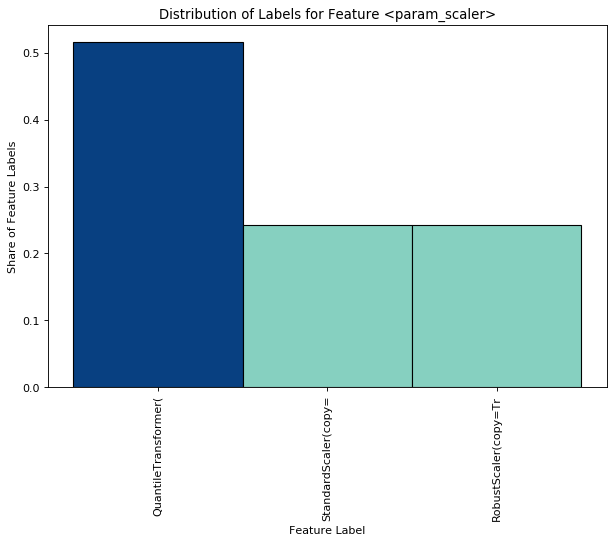

In [179]:
# View best scaler
name = 'scaler'

indexList=[results_run1.loc[results_run1['param_' + name]==results_run1['param_' + name].unique()[i]].iloc[0,:].name for i in range(0,len(merged_params_run1[name]))]
print("Plot best {} values".format(name))
display(results_run1.loc[indexList].round(3))

#number of results to consider
number_results = np.int(results_run1.shape[0]*0.10)
print("The top 10% of the results are used, i.e {} samples".format(number_results))
histlabel = results_run1['param_' + name][0:number_results]#.apply(str).apply(lambda x: x[:20])
source = histlabel.value_counts()/number_results
f = vis.paintBarChartForCategorical(source.index, source)

[StandardScaler(copy=True, with_mean=True, with_std=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True), QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000), Normalizer(copy=True, norm='l2')]
scaler


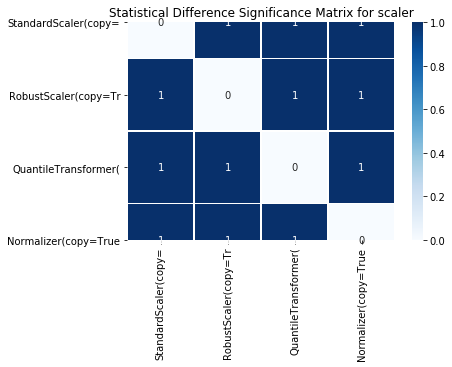

In [180]:
_ = calculate_significance_matrix(name, merged_params_run1[name], results_run1)

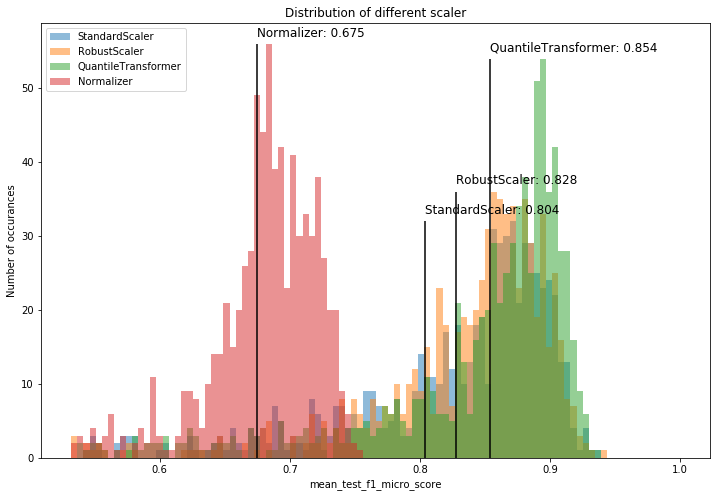

In [181]:
median_list = plotOverlayedHistorgrams(name, merged_params_run1[name], results_run1)

In [182]:
#Get the best scaler from median
best_scaler = max(median_list, key=median_list.get) #source.idxmax()
print("Best scaler: ", best_scaler)

Best scaler:  QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)


### Run1: Best Sampler

Plot best sampling values


,mean_test_f1_score,std_test_f1_score,param_scaler,param_sampling,param_feat__cols,param_svm__C,param_svm__kernel,param_svm__degree,param_svm__gamma
10,0.942,0.044,"RobustScaler(copy=True, quantile_range=(25.0, ...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,linear,NaN,NaN
2387,0.930,0.035,"QuantileTransformer(copy=True, ignore_implicit...","ADASYN(n_jobs=None, n_neighbors=5, random_stat...","[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",10,rbf,NaN,10
1118,0.929,0.048,"QuantileTransformer(copy=True, ignore_implicit...","SMOTE(k_neighbors=5, n_jobs=None, random_state...","[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",1,poly,2,NaN
76,0.928,0.041,"StandardScaler(copy=True, with_mean=True, with...","SMOTETomek(n_jobs=None, random_state=None, sam...","[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,linear,NaN,NaN
2291,0.910,0.047,"QuantileTransformer(copy=True, ignore_implicit...","SMOTEENN(enn=None, n_jobs=None, random_state=N...","[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",10,rbf,NaN,10


The top 10% of the results are used, i.e 384 samples


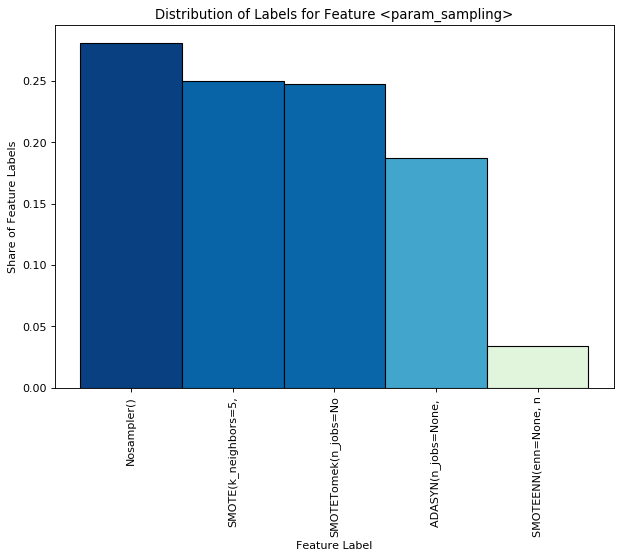

In [183]:
# View best sampler
name = 'sampling'
print("Plot best {} values".format(name))

#results[result_columns].loc[results.param_scaler.ne('Normalizer(copy=True, norm=\'l2\')').idxmax()]
indexList=[results_run1.loc[results_run1['param_' + name]==results_run1['param_' + name].unique()[i]].iloc[0,:].name for i in range(0,len(merged_params_run1[name]))]
display(results_run1.loc[indexList].round(3))

#number of results to consider
number_results = np.int(results_run1.shape[0]*0.10)
print("The top 10% of the results are used, i.e {} samples".format(number_results))
histlabel = results_run1['param_' + name][0:number_results]#.apply(str).apply(lambda x: x[:9])
#print("Column {} is a categorical string".format(results.columns['param_scaler']))
source = histlabel.value_counts()/number_results
f=vis.paintBarChartForCategorical(source.index, source)

[Nosampler(), SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto'), SMOTEENN(enn=None, n_jobs=None, random_state=None, sampling_strategy='auto',
         smote=None), SMOTETomek(n_jobs=None, random_state=None, sampling_strategy='auto', smote=None,
           tomek=None), ADASYN(n_jobs=None, n_neighbors=5, random_state=None, sampling_strategy='auto')]
sampling


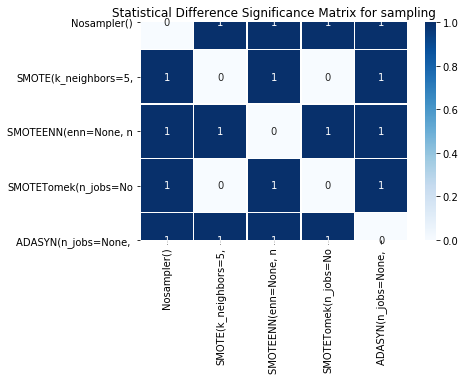

In [184]:
_ = calculate_significance_matrix(name, merged_params_run1[name], results_run1)

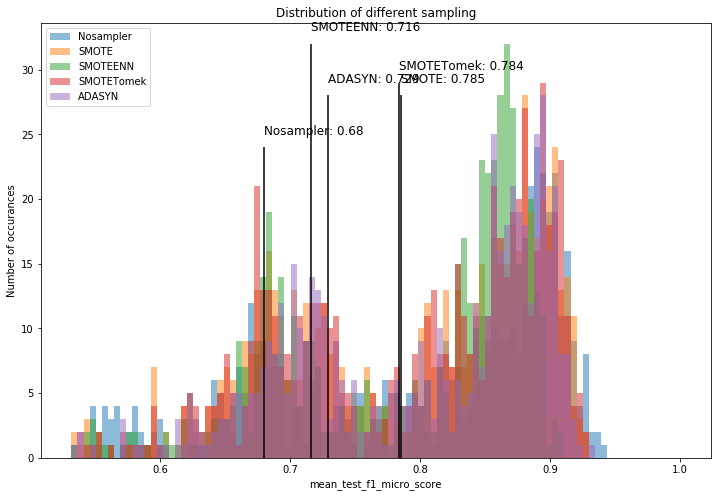

In [185]:
median_list = plotOverlayedHistorgrams(name, merged_params_run1[name], results_run1)

In [186]:
#Get the best sampler
best_sampler = max(median_list, key=median_list.get) #source.idxmax()
print("Best {}: {}".format(name, best_sampler))

Best sampling: SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto')


### Run1: Best kernel

,mean_test_f1_score,std_test_f1_score,param_scaler,param_sampling,param_feat__cols,param_svm__C,param_svm__kernel,param_svm__degree,param_svm__gamma
10,0.942,0.044,"RobustScaler(copy=True, quantile_range=(25.0, ...",Nosampler(),"[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109...",10,linear,NaN,NaN
1094,0.938,0.047,"QuantileTransformer(copy=True, ignore_implicit...",Nosampler(),"[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",1,poly,2,NaN
2387,0.930,0.035,"QuantileTransformer(copy=True, ignore_implicit...","ADASYN(n_jobs=None, n_neighbors=5, random_stat...","[2, 3, 4, 7, 8, 9, 22, 23, 24, 25, 26, 27, 28,...",10,rbf,NaN,10
795,0.907,0.052,"StandardScaler(copy=True, with_mean=True, with...","SMOTETomek(n_jobs=None, random_state=None, sam...","[1, 2, 3, 4, 5, 7, 8, 9, 23, 24, 25, 26, 27, 2...",1,sigmoid,NaN,NaN


The top 10% of the results are used, i.e 384 samples


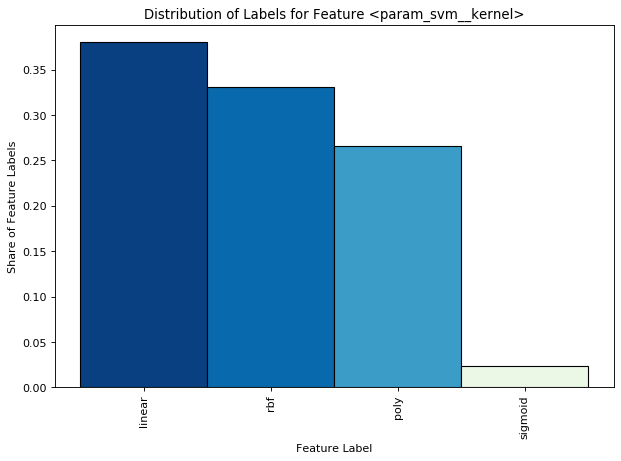

In [187]:
# View best kernel
name = 'svm__kernel'

kernels = ['linear', 'sigmoid', 'poly', 'rbf'] #Hack. This should be taken from the dicts
indexList=[results_run1.loc[results_run1['param_' + name]==results_run1['param_' + name].unique()[i]].iloc[0,:].name for i in range(0,len(kernels))]
display(results_run1.loc[indexList].round(3))

#number of results to consider
number_results = np.int(results_run1.shape[0]*0.10)
print("The top 10% of the results are used, i.e {} samples".format(number_results))
histlabel = results_run1['param_' + name][0:number_results]#.apply(str).apply(lambda x: x[:20])
source = histlabel.value_counts()/number_results
f=vis.paintBarChartForCategorical(source.index, source)

['linear', 'sigmoid', 'poly', 'rbf']
svm__kernel


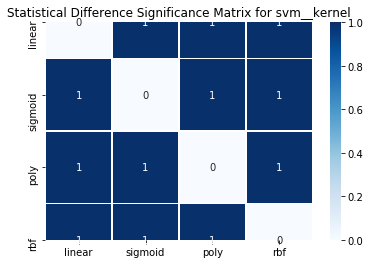

In [188]:
_ = calculate_significance_matrix(name, kernels, results_run1)

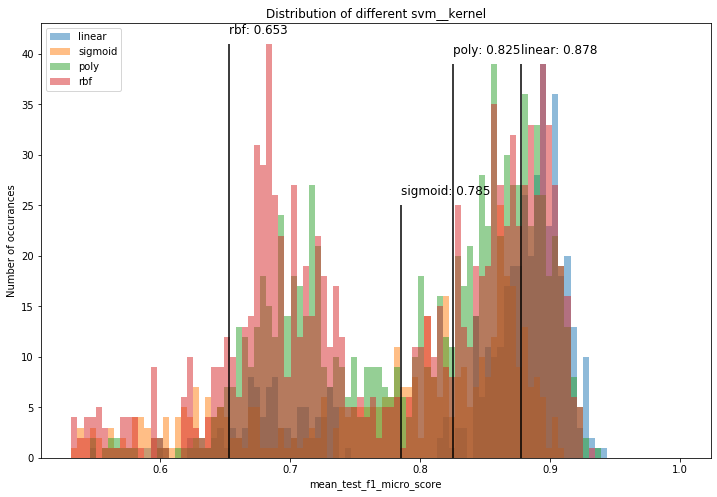

In [189]:
median_list = plotOverlayedHistorgrams(name, kernels, results_run1)

In [190]:
#Get the best kernel
best_kernel = max(median_list, key=median_list.get) #source.idxmax()
print("Best {}: {}".format(name, best_kernel))

Best svm__kernel: linear


### Run 1: Best Feature Selection

In [191]:
#Replace the parameters in the model with the name to better see the parameter setting
#feature_dict2 = dict(zip(df_feature_columns.columns, selected_features))
#number_results = 500
number_results = np.int(results_run1.shape[0]*0.10)
print("The top 10% of the results are used, i.e {} samples".format(number_results))

#display(feature_dict2)

result_subset_run1 = results_run1.iloc[0:number_results,:].copy()

def list_to_name(list_of_lists, list_names, result):
    for k, value in enumerate(result):
        indices = [i for i, x in enumerate(list_of_lists) if x == value]
        if len(indices)>0:
            first_index = indices[0]
            result.iloc[k] = list_names[first_index]
        if k%50==0:
            print("run ", k)
    
    #for j, k in enumerate(result_subset_run1['param_feat__cols']):
    #    for i in feature_dict.keys():
    #        if result_subset_run1['param_feat__cols'].iloc[j] == feature_dict.get(i):
    #            result_subset_run1['param_feat__cols'].iloc[j] = i
    #            #print(j)

print("Convert list to name")
list_to_name(selected_features, df_feature_columns.columns, result_subset_run1['param_feat__cols'])

The top 10% of the results are used, i.e 384 samples
Convert list to name
run  0
run  50
run  100
run  150
run  200
run  250
run  300
run  350


C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,mean_test_f1_score,std_test_f1_score,param_scaler,param_sampling,param_feat__cols,param_svm__C,param_svm__kernel,param_svm__degree,param_svm__gamma
10,0.942,0.044,"RobustScaler(copy=True, quantile_range=(25.0, ...",Nosampler(),Lasso,10,linear,NaN,NaN
1094,0.938,0.047,"QuantileTransformer(copy=True, ignore_implicit...",Nosampler(),Tree,1,poly,2,NaN
752,0.928,0.044,"RobustScaler(copy=True, quantile_range=(25.0, ...","SMOTE(k_neighbors=5, n_jobs=None, random_state...",Manual,1,linear,NaN,NaN
254,0.925,0.059,"QuantileTransformer(copy=True, ignore_implicit...",Nosampler(),Backward_Elimination,1,linear,NaN,NaN
2789,0.913,0.052,"StandardScaler(copy=True, with_mean=True, with...","SMOTETomek(n_jobs=None, random_state=None, sam...",RecursiveTop32,1,rbf,NaN,0.1
560,0.910,0.056,"RobustScaler(copy=True, quantile_range=(25.0, ...","SMOTETomek(n_jobs=None, random_state=None, sam...",RecursiveTop64,1,linear,NaN,NaN
840,0.902,0.054,"StandardScaler(copy=True, with_mean=True, with...",Nosampler(),All,0.1,linear,NaN,NaN
614,0.901,0.055,"QuantileTransformer(copy=True, ignore_implicit...",Nosampler(),RecursiveTop96,1,linear,NaN,NaN


The top 10% of the results are used, i.e 384 samples


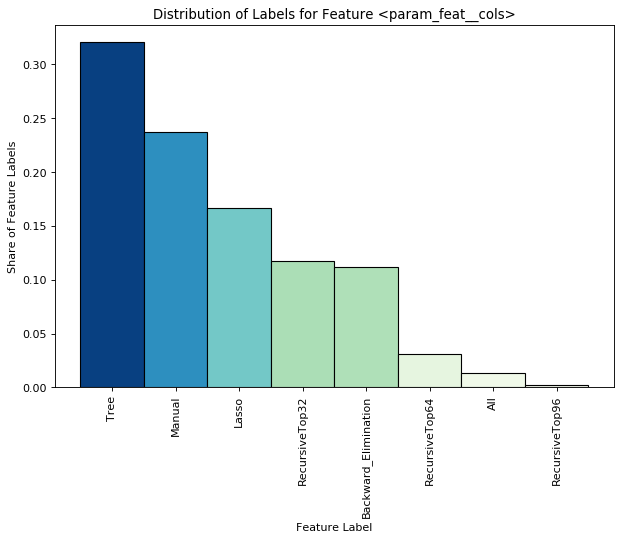

In [192]:
# View best number of features
name = 'feat__cols'

indexList=[result_subset_run1.loc[result_subset_run1['param_' + name]==result_subset_run1['param_' + name].unique()[i]].iloc[0,:].name for i in range(0,len(result_subset_run1['param_' + name].unique()))]
#ndexList
display(result_subset_run1.loc[indexList].round(3))

#number of results to consider
#number_results = 20
number_results = np.int(results_run1.shape[0]*0.10)

print("The top 10% of the results are used, i.e {} samples".format(number_results))
histlabel = result_subset_run1['param_' + name][0:number_results]
source = histlabel.value_counts()/number_results
f=vis.paintBarChartForCategorical(source.index, source)

The statistical significance matrix shows if distributions differ significantly from each other. If the value between two distributions are 0, they do not differ. If the value is 1, there is a significant difference between the distributions.

Index(['Lasso', 'Tree', 'Backward_Elimination', 'RecursiveTop32',
       'RecursiveTop64', 'RecursiveTop96', 'Manual', 'All'],
      dtype='object')
feat__cols


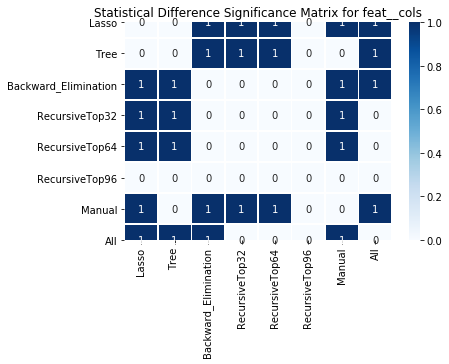

In [193]:
_ = calculate_significance_matrix(name, df_feature_columns.columns, result_subset_run1)

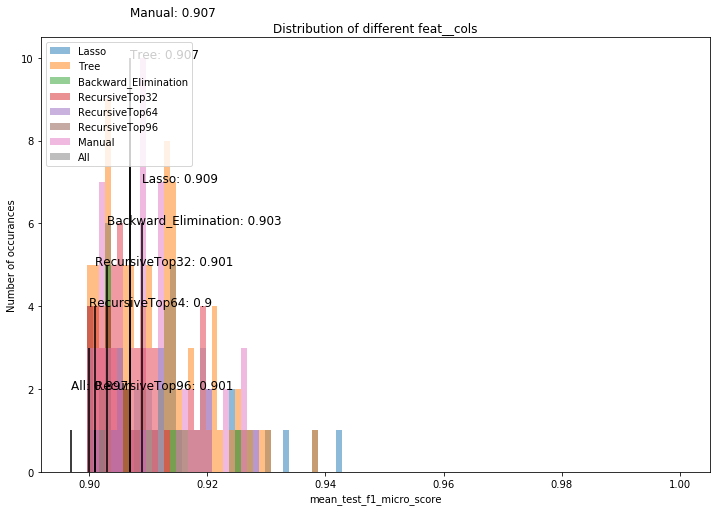

In [194]:
median_list = plotOverlayedHistorgrams(name, df_feature_columns.columns, result_subset_run1)

In [195]:
#Get best feature result
#Get the best kernel
best_feature_combi = max(median_list, key=median_list.get) #source.idxmax()
#print("Best {}: {}".format(name, best_feature_combi))
best_columns = feature_dict.get(best_feature_combi)

print("Best feature selection: ", best_feature_combi)#results_run1[result_columns_run1].loc[indexList]['param_feat__cols'].iloc[select_index])
print("Column indices: ", best_columns)#feature_dict.get((results_run1[result_columns_run1].loc[indexList]['param_feat__cols'].iloc[best_feature_combi])))
print("Column names: ", X_train.columns[best_columns])#X_train.columns[feature_dict.get((results_run1[result_columns_run1].loc[indexList]['param_feat__cols'].iloc[best_feature_combi]))])


Best feature selection:  Lasso
Column indices:  [1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94, 109, 113, 114, 115, 117, 118]
Column names:  Index(['NormKurs20', 'NormKurs200', 'NumberRise5', 'NumberRise20',
       'NumberRise50', 'NumberRise200', 'MA150Norm', 'RSI_14', 'RSI3sign',
       'MACD_5_35_5', 'MACD_12_26_9Diff', 'MACDS_12_26_9Diff', 'month_year__1',
       'month_year__5', 'month_year__6', 'month_year__7', 'month_year__9',
       'month_year__10'],
      dtype='object')


In [196]:
#Get top parameters from the first gridsearch to fix them
run1_bestparameters = gridsearch_run1.best_params_
#best_scaler = run1_bestparameters['scaler']
print("Best scaler", best_scaler)
#best_sampling = run1_bestparameters['sampling']
print("Best sampling", best_sampler)
#best_columns = run1_bestparameters['feat__cols']
print("Best selected features", best_feature_combi)
print("Columns={}".format( X_train.columns[best_columns]))
#best_kernel = run1_bestparameters['svm__kernel']
print("Best kernel", best_kernel)
#print("Best result: ", gridsearch_run1.best_score_)

Best scaler QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)
Best sampling SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto')
Best selected features Lasso
Columns=Index(['NormKurs20', 'NormKurs200', 'NumberRise5', 'NumberRise20',
       'NumberRise50', 'NumberRise200', 'MA150Norm', 'RSI_14', 'RSI3sign',
       'MACD_5_35_5', 'MACD_12_26_9Diff', 'MACDS_12_26_9Diff', 'month_year__1',
       'month_year__5', 'month_year__6', 'month_year__7', 'month_year__9',
       'month_year__10'],
      dtype='object')
Best kernel linear


### Run 2: Exhaustive Hyper Parameter Selection Through Wide Grid Search of Subset
The basic parameters have been set. Now make an exhaustive parameter search for tuning parameters. Only a few samples are used and low kfold just to find the parameter limits

In [200]:
#Main set of parameters for the grid search run 2: Select solver parameter
number_of_samples = 600

In [201]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, Normalizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import feature_selection
from imblearn.pipeline import Pipeline

def grid_search_for_results(X_train, y_train, pipe_run, params, number_of_samples=400, kfold=5):
    '''Execute grid seach for a given pipe and params'''
    X_train_subset, y_train_subset = extract_data_subset(X_train, y_train, number_of_samples)

    skf = StratifiedKFold(n_splits=kfold)

    gridsearch_run = GridSearchCV(pipe_run, params, verbose=3, cv=skf, scoring=scorers, refit=refit_scorer_name, 
                   return_train_score=True, iid=True, n_jobs=-1).fit(X_train_subset, y_train_subset)
    print('Final score is: ', gridsearch_run.score(X_test, y_test))
    print('Bets estimator: ', gridsearch_run.best_estimator_)
    
    results = generate_result_table(gridsearch_run, params, refit_scorer_name)
    
    return results, gridsearch_run

In [202]:
#Main set of parameters for the grid search run 2: Select solver parameter

if best_kernel is 'rbf':
    params_run2 = { 
            'svm__C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5], 
            'svm__gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
            }
elif best_kernel is 'linear'or best_kernel is 'sigmoid':
    params_run2 = { 
            'svm__C':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 
            'svm__gamma': [1e0, 1e1]
            }
elif best_kernel is 'poly':
        params_run2 = { 
            'svm__C':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 
            'svm__gamma': [1e0, 1e1]
            }

pipe_run2 = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel))
        ])

In [203]:
results, gridsearch_run2 = grid_search_for_results(X_train, y_train, pipe_run2, params_run2, number_of_samples=number_of_samples, kfold=5)
results.round(3).head(20)

Original size X:  (6122, 127)
Original size y:  (6122,)
Quota of samples used in the optimization: 0.10
Subset size X:  (600, 127)
Subset size y:  (600,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.2s finished
C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (600). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


Final score is:  0.8343110439043193
Bets estimator:  Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('feat',
                 ColumnExtractor(cols=[1, 4, 5, 6, 7, 9, 25, 67, 78, 91, 93, 94,
                                       109, 113, 114, 115, 117, 118])),
                ('svm',
                 SVC(C=10000.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1.0,
                     kernel='linear', max_iter=-1, probability=False,
          

,mean_test_f1_score,std_test_f1_score,param_svm__C,param_svm__gamma
16,0.928,0.018,10000,1
17,0.928,0.020,10000,10
13,0.926,0.021,100,10
10,0.924,0.015,10,1
14,0.924,0.016,1000,1
12,0.923,0.015,100,1
9,0.923,0.013,1,10
11,0.921,0.019,10,10
8,0.921,0.017,1,1
15,0.917,0.020,1000,10


In [204]:
#results = generate_result_table(gridsearch_run2, params_run2, refit_scorer_name)


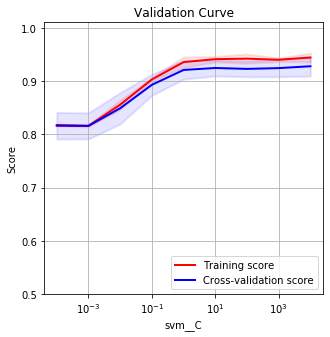

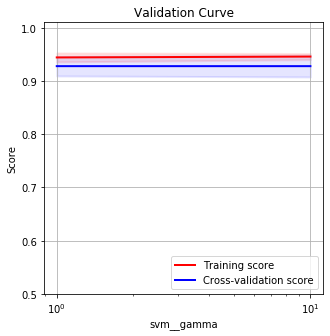

In [205]:
def plot_grid_search_validation_curve(grid, param_to_vary, title='Validation Curve', ylim=None, xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""
    #https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_' + refit_scorer_name]
    valid_scores_mean = df_cv_results['mean_test_' + refit_scorer_name]
    train_scores_std = df_cv_results['std_train_' + refit_scorer_name]
    valid_scores_std = df_cv_results['std_test_' + refit_scorer_name]

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.figure(figsize=(5,5))
    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    #if (not isinstance(param_range[0], numbers.Number)):
    #    param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    plt.legend(loc='lower right')
    plt.grid()

    plt.show()

plot_grid_search_validation_curve(gridsearch_run2, 'svm__C', log=True, ylim=(0.50, 1.01))
plot_grid_search_validation_curve(gridsearch_run2, 'svm__gamma', log=True, ylim=(0.50, 1.01))

In [206]:
%matplotlib inline

def plot_heatmap_xy(scores, parameters, xlabel, ylabel, title, normalizeScale=False):
    # Source of inspiration: https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html

    #Plot a heatmap of 2 variables
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True, sharey=True)
    #fig = plt.figure(figsize=(7,5), constrained_layout=True)
    #ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    #ax=axs[0]
    
    #ax=plt.gca()
    colorMap = plt.cm.bone #plt.cm.gist_gray #plt.cm.hot
    
    if normalizeScale==True:
        im1 = plt.imshow(scores, interpolation='catrom', cmap=colorMap, vmin=0 , vmax=1)
    else:
        #im1 = plt.imshow(scores, interpolation='nearest', cmap=colorMap)
        im1 = plt.imshow(scores, interpolation='catrom', origin='lower', cmap=colorMap)

    levels = np.linspace(np.min(scores), np.max(scores), 20)
        
   # contours = plt.contour(scores, 10, colors='black')
    #contours = plt.contour(scores, 10, colors='black')
    contours = ax.contourf(scores, levels=levels, cmap=plt.cm.bone)
    
    ax.contour(scores, levels=levels, colors='k', linestyles='solid', alpha=1, linewidths=.5, antialiased=True)
    
    #plt.contourf = 
    ax.clabel(contours, inline=True, fontsize=8, colors='r')    
    
    #Get best value
    def get_Top_n_values_from_array(arr, n):
        result = []
        for i in range(1,n+1):
            x = np.partition(arr.flatten(), -2)[-i]
            r = np.where(arr == x)
            #print(r[0][0], r[1][0])
            value = [r[0][0], r[1][0]]
            result.append(value)
        return result
    
    bestvalues = get_Top_n_values_from_array(scores, 10)
    [plt.plot(pos[1], pos[0], 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="best_value") for pos in bestvalues]
    #best = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
    #print(best)
    #plt.plot(parameters[xlabel][best[1]], parameters[ylabel][best[0]], 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="value1")
    #plt.plot(3, 8, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="value1")
    
    plt.sca(ax)
    plt.xticks(np.arange(len(parameters[xlabel])), ['{:.1E}'.format(x) for x in parameters[xlabel]], rotation='vertical')
    plt.yticks(np.arange(len(parameters[ylabel])), ['{:.1E}'.format(x) for x in parameters[ylabel]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, len(parameters[xlabel])-1)
    plt.ylim(0, len(parameters[ylabel])-1)
    ax.set_title(title)
    
    #cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.8])
    cbar = fig.colorbar(im1, ax=ax) #cax=axs[1])
    plt.show()

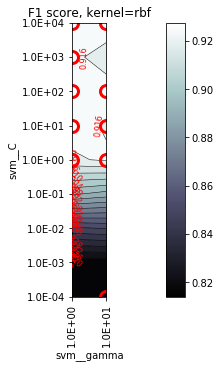

In [207]:
#Select variables to visualize
indexes = [i for i, item in enumerate(gridsearch_run2.cv_results_['params'])]

#Create a matrix of y=alpha, x=hidden layers
scores = gridsearch_run2.cv_results_['mean_test_' + refit_scorer_name][indexes].reshape(len(params_run2['svm__C']), len(params_run2['svm__gamma']))
plot_heatmap_xy(scores, params_run2, 'svm__gamma', 'svm__C', 'F1 score, kernel=rbf')

In [208]:
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from scipy.stats import reciprocal

def generate_parameter_limits(results, plot_best=20):
    #Get limits of the best values and focus in this area
    param_svm_C_minmax = pd.Series(data=[np.min(results['param_svm__C'].head(plot_best)), np.max(results['param_svm__C'].head(plot_best))], 
              index=['min', 'max'], name='param_svm__C')

    param_svm_gamma_minmax = pd.Series(data=[np.min(results['param_svm__gamma'].head(plot_best)), np.max(results['param_svm__gamma'].head(plot_best))], 
              index=['min', 'max'], name='param_svm__gamma')

    parameter_svm = pd.DataFrame([param_svm_C_minmax, param_svm_gamma_minmax])
    
    return parameter_svm

In [209]:
parameter_svm = generate_parameter_limits(results)
display(parameter_svm)

,min,max
param_svm__C,0.0001,10000.0
param_svm__gamma,1.0000,10.0


### Run 3: Randomized space search to find optimal maximum

In [210]:
#Generate Scatter plot with results
def visualize_random_search_results(random_search, refit_scorer_name):
    cols = random_search.cv_results_['mean_test_' + refit_scorer_name]
    x=random_search.cv_results_['param_svm__C']
    y=random_search.cv_results_['param_svm__gamma']

    fig = plt.figure()
    ax = plt.gca()
    sc = ax.scatter(x=x,y=y,s=50,c=cols, alpha=0.5, edgecolors='none', cmap=plt.cm.bone)
    #ax.pcolormesh(x, y, cols, cmap=plt.cm.BuGn_r)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([np.min(x), np.max(x)])
    ax.set_ylim([np.min(y), np.max(y)])
    plt.grid(True)
    plt.colorbar(sc)
    
    return ax

In [211]:
#Define pipeline, which is constant for all tests
pipe_run_random = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel))
        ])

In [212]:
from scipy.stats import uniform
from scipy.stats import reciprocal
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
#from sklearn.model_selection import train_test_split
#import time

def random_cv(X_train, y_train, parameter_svm, pipe_run, number_of_samples=400, kfolds=5, n_iter_search=2000, plot_best=20):
    
    #Extract data subset to train on
    X_train_subset, y_train_subset = extract_data_subset(X_train, y_train, number_of_samples)
    
    #Main set of parameters for the grid search run 2: Select solver parameter
    params_run = { 
            'svm__C': reciprocal(parameter_svm.loc['param_svm__C']['min'], parameter_svm.loc['param_svm__C']['max']), 
            'svm__gamma': reciprocal(parameter_svm.loc['param_svm__gamma']['min'], parameter_svm.loc['param_svm__gamma']['max'])
            }

#    pipe_run = Pipeline([
#            ('scaler', best_scaler),
#            ('sampling', best_sampler),
#            ('feat', ColumnExtractor(cols=best_columns)),
#            ('svm', SVC(kernel=best_kernel))
#            ])
    
    #K-Fold settings
    skf = StratifiedKFold(n_splits=kfolds)

    # run randomized search
    random_search_run = RandomizedSearchCV(pipe_run, param_distributions=params_run, n_jobs=-1,
                                       n_iter=n_iter_search, cv=skf, scoring=scorers, 
                                       refit=refit_scorer_name, iid=True, verbose=5)

    random_search_run.fit(X_train_subset, y_train_subset)
    print("Best parameters: ", random_search_run.best_params_)
    print("Best score: {:.3f}".format(random_search_run.best_score_))
    
    #Create the result table
    results = generate_result_table(random_search_run, params_run, refit_scorer_name)
    #Display results
    display(results.round(3).head(5))
    
    #Plot results
    ax = visualize_random_search_results(random_search_run, refit_scorer_name)
    #Plot best results
    [ax.plot(p[0], p[1], 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="best_value") for p in zip(results['param_svm__C'].head(plot_best).values, results['param_svm__gamma'].head(plot_best).values)]    
    plt.show()

    #Get limits of the best values and focus in this area
    parameter_svm = generate_parameter_limits(results)
    #display(parameter_svm)
    
    return parameter_svm, results, random_search_run

Start random optimization with the following parameters: 
Sample size:  600
Number of folds:  3
Number of tries:  2000
Number of best results to select from:  50
Original size X:  (6122, 127)
Original size y:  (6122,)
Quota of samples used in the optimization: 0.10
Subset size X:  (600, 127)
Subset size y:  (600,)
Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 978 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1554 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 2274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2688 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4146 tasks      | ela

Best parameters:  {'svm__C': 22.591008164647988, 'svm__gamma': 9.680650784778251}
Best score: 0.937


,mean_test_f1_score,std_test_f1_score,param_svm__C,param_svm__gamma
1541,0.937,0.006,22.591,9.68065
865,0.935,0.008,5.1127,3.12526
1817,0.935,0.010,12.2877,2.82395
1413,0.935,0.002,115.655,4.09469
1566,0.935,0.007,1106.35,3.30719


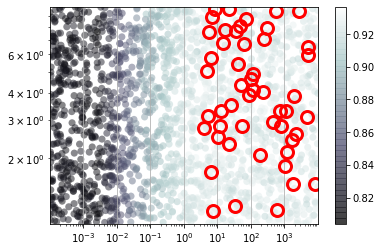

Got best parameters: 


,min,max
param_svm__C,4.862865,8055.226561
param_svm__gamma,1.529356,9.680651


Start random optimization with the following parameters: 
Sample size:  800
Number of folds:  5
Number of tries:  6000
Number of best results to select from:  50
Original size X:  (6122, 127)
Original size y:  (6122,)
Quota of samples used in the optimization: 0.13
Subset size X:  (800, 127)
Subset size y:  (800,)
Fitting 5 folds for each of 6000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  3.4min


KeyboardInterrupt: 

In [213]:
#Iterated pipeline with increasing number of tries
#sample_size = [400, 600, 2000, 6000]
#kfolds = [3, 3, 5, 5]
#number_of_interations = [2000, 1500, 1000, 100]
#select_from_best = [20, 20, 20, 20]

sample_size = [600, 800]
kfolds = [3, 5]
number_of_interations = [2000, 6000]
select_from_best = [50, 50]

combined_parameters = zip(sample_size, kfolds, number_of_interations, select_from_best)

new_parameter_rand = parameter_svm

for sample_size, folds, iterations, selection in combined_parameters:
    print("Start random optimization with the following parameters: ")
    print("Sample size: ", sample_size)
    print("Number of folds: ", folds)
    print("Number of tries: ", iterations)
    print("Number of best results to select from: ", selection)
    
    new_parameter_rand, results_random_search, clf = random_cv(X_train, y_train, new_parameter_rand, pipe_run_random, 
                                   number_of_samples=sample_size, kfolds=folds, 
                                   n_iter_search=iterations, plot_best=selection)
    print("Got best parameters: ")
    display(new_parameter_rand)

In [ ]:
print("Best parameter limits: ")
display(new_parameter_rand)

print("Best results: ")
display(results_random_search.round(3).head(20))

### Run 4: Run best parameters from the intense random search
Make a lot of random searches and narrow it by testing less points but with more samples until only 10 is missing

In [ ]:
def create_parameter_grid_for_svm(results, top_results=None):
    '''Get the top x results from the result list and create a parameter list from it'''
    
    if top_results is None:
        top_results = results.shape[0]
    
    params_new = []
    for i in range(top_results):
        new_dict = {}
        new_dict['svm__C'] = [results.iloc[i]['param_svm__C']]
        new_dict['svm__gamma'] = [results.iloc[i]['param_svm__gamma']]
        params_new.append(new_dict)
        
    return params_new

In [ ]:
pipe_run_grid = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel))
        ])

In [ ]:
params_grid_iter = create_parameter_grid_for_svm(results_random_search, top_results=100)
print("Number of initial combinations", len(params_grid_iter))
display(params_grid_iter[0:10])

In [ ]:
sample_size = [400, 1000, 3000, 6000]
kfolds = [5, 5, 5]
select_from_best = [50, 10, 3, 3]

combined_parameters = zip(sample_size, kfolds, select_from_best)

new_parameter_rand = params_grid_iter

for sample_size, folds, selection in combined_parameters:
    print("Start random optimization with the following parameters: ")
    print("Sample size: ", sample_size)
    print("Number of folds: ", folds)
    print("Number of best results to select from: ", selection)
    
    results_deep, gridsearch_run = grid_search_for_results(X_train, y_train, pipe_run_grid, new_parameter_rand, number_of_samples=sample_size, kfold=folds)
    display(results_deep.round(3).head(5))

    print("Got best parameters: ")
    display(new_parameter_rand)
    
    #Plot results
    ax = visualize_random_search_results(clf, refit_scorer_name)
    #Plot best results
    [ax.plot(p[0], p[1], 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="best_value") for p in zip(results['param_svm__C'].head(selection).values, results['param_svm__gamma'].head(selection).values)]    
    plt.show()
    
    new_parameter_rand = create_parameter_grid_for_svm(results_deep, top_results=selection)
    print("Created new ")


#### Print best result, the final result for hyper parameters

In [ ]:
#Create the result table
display(results_deep.round(3).head(1))
    
param_final = new_parameter_rand[0]
print("Hyper parameters found")
display(param_final)

In [ ]:
#Save the hyper parameters
import json

# save the optimal precision/recall value to disk
print("Save hyper parameters to disk")
with open(default_hyper_parameters_filename, 'w') as fp:
    json.dump(param_final, fp)
print("Saved hyper parameters to disk: ", default_hyper_parameters_filename)

# Optimize Precision/Recall Threshold

Split the training set into 2 partitions and find the optimal precision/recall threshold from that training set. Train on the whole training dataset, first without any precision/recall adjustment. Then, if the classes are binarized, precision/recall optimization is performed.

Note: This adjustment is only done on binarized classes and skipped for multi class problems.

In [67]:
#Default optimal precision/recall threshold
optimal_threshold = 0.0

if is_multiclass is True:
    print("The problem is a multi class problem. No precision/recall optimization will be done.")
else:
    print("The problem is a binary class problem. Perform precision/recall analysis.")

The problem is a binary class problem. Perform precision/recall analysis.


In [68]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

#Split the training set in a train_sub and cross_sub set to select the optimal precision/recall threshold

from sklearn.model_selection import train_test_split

#Split test and training sets
### WARNING: Data is not shuffled for this example ####
X_trainsub, X_cross, y_trainsub, y_cross = train_test_split(X_train, y_train, random_state=0, test_size=0.2, shuffle=True, stratify = y_train) #cross validation size 20
print("Total number of samples: {}. X_trainsub: {}, X_cross: {}, y_trainsub: {}, y_cross: {}".format(X_train.shape[0], X_trainsub.shape, X_cross.shape, y_trainsub.shape, y_cross.shape))

Total number of samples: 6149. X_trainsub: (4919, 127), X_cross: (1230, 127), y_trainsub: (4919,), y_cross: (1230,)


#### Load existing model and/or parameters

In [69]:
#Apply final parameters
#Either use the currently found parameters
print("Original final parameters: ", param_final)

#or use customized, known parameters
#param_final = {'svm__C': [35.00964852688157], 'svm__gamma': [0.1761212691035545]}
#print("New final parameters: ", param_final)

#TODO Add possibility to load parameters from file as final parameter

Original final parameters:  {'svm__C': [4.895467982642922], 'svm__gamma': [7.525818386930191]}


In [70]:
# Load an existing model to be used optimized with precision recall parameters
#from sklearn.externals import joblib

#loaded_model = joblib.load(model_filename)
#print("Loaded trained model from ", model_filename)
#print("Model", loaded_model)
print("Use currently trained model.")

Use currently trained model.


#### Train new model from optimal parameters

In [71]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

# Train an SVM
from sklearn import svm
import time

number_of_samples = 1000000

display(param_final)
pipe_final = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel, probability=True))
        ])

display(pipe_final)

t=time.time()
local_time = time.ctime(t)
print("=== Start training the SVM at {} ===".format(local_time))

results, gridsearch_pr = grid_search_for_results(X_trainsub, y_trainsub, pipe_final, param_final, number_of_samples=number_of_samples, kfold=5)

#optclf = svm.SVC(probability=True, C=0.5, gamma=1, kernel='rbf', verbose=True)
#optclf = gridsearch_run2#svm.SVC(probability=True, C=564, gamma=0.013, kernel='rbf', verbose=True)
#optclf.fit(X_train_shuffled.iloc[X_train_index_subset,:].values, y_train_shuffled[X_train_index_subset])
elapsed = time.time() - t
print("Training took {}s".format(elapsed))
print("Training finished")

{'svm__C': [4.895467982642922], 'svm__gamma': [7.525818386930191]}

Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

=== Start training the SVM at Wed Dec 18 12:21:54 2019 ===
Original size X:  (4919, 127)
Original size y:  (4919,)
Subset size X:  (4919, 127)
Subset size y:  (4919,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Final score is:  0.8740722978939919
Bets estimator:  Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=4.895467982642922, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=7.525818386930191, kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.0

In [72]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

#Select the optimal model
#If new model has been trained
optclf = gridsearch_pr.best_estimator_

#If old model is used
#optclf = loaded_model

#### Create Predictions

In [73]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

print("Predict training data")
y_trainsub_pred = optclf.predict(X_trainsub.values)
y_trainsub_pred_scores = optclf.decision_function(X_trainsub.values)
y_trainsub_pred_proba = optclf.predict_proba(X_trainsub.values)

print("Predict y_cross")
y_cross_pred = optclf.predict(X_cross.values)
print("Predict probabilities and scores")
y_cross_pred_proba = optclf.predict_proba(X_cross.values)
y_cross_pred_scores = optclf.decision_function(X_cross.values)
print('Model properties: ', optclf)

Predict training data
Predict y_cross
Predict probabilities and scores
Model properties:  Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=4.895467982642922, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=7.525818386930191, kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinki

In [74]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

#Prepare the class list for classes, in case a class does not exist in the y_true and y_pred, which exist in y_train
a=np.unique(y_cross)
b=np.unique(y_cross_pred)
c=np.hstack((a, b))
d=np.unique(c)
existing_classes=[]
[existing_classes.append(y_classes[i]) for i in d]
existing_classes

#### Evaluate performance on Training data

Accuracy:  0.9221386460662736
              precision    recall  f1-score   support

    Negative       0.90      0.86      0.88      1637
    Positive       0.93      0.95      0.94      3282

    accuracy                           0.92      4919
   macro avg       0.92      0.91      0.91      4919
weighted avg       0.92      0.92      0.92      4919

Normalized confusion matrix
[[0.865 0.135]
 [0.049 0.951]]


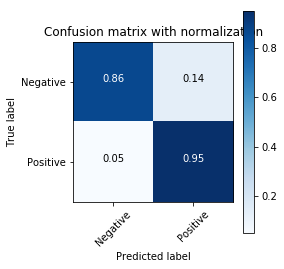

Plot ROC curve


<Figure size 864x576 with 0 Axes>

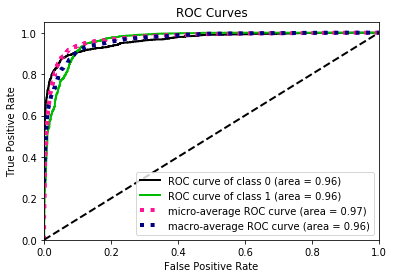

In [75]:
%%skip $is_multiclass #skip if the problem is a multiclass problem
#%matplotlib inline

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

#Calculate Precision, Recall, Accuracy, F1, Confusion Matrix, ROC
print("Accuracy: ", accuracy_score(y_trainsub, y_trainsub_pred))
print(classification_report(y_trainsub, y_trainsub_pred, target_names=existing_classes))

cnf_matrix = confusion_matrix(y_trainsub, y_trainsub_pred, labels=d)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
matrixSize = len(y_classes)*2
plt.figure(figsize=(matrixSize, matrixSize))
_ = vis.plot_confusion_matrix_multiclass(cnf_matrix, classes=existing_classes, title='Confusion matrix with normalization', normalize=True)
plt.show()

plt.figure(figsize=(12, 8))
print("Plot ROC curve")
_ = skplt.metrics.plot_roc(np.array(y_trainsub), np.array(y_trainsub_pred_proba))
plt.show()

#### Evaluate performance on Test data

Accuracy:  0.932520325203252
              precision    recall  f1-score   support

    Negative       0.91      0.88      0.90       409
    Positive       0.94      0.96      0.95       821

    accuracy                           0.93      1230
   macro avg       0.93      0.92      0.92      1230
weighted avg       0.93      0.93      0.93      1230

Normalized confusion matrix
[[0.88  0.12 ]
 [0.041 0.959]]


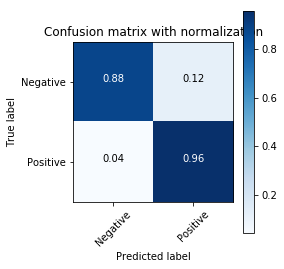

Plot ROC curve


<Figure size 864x576 with 0 Axes>

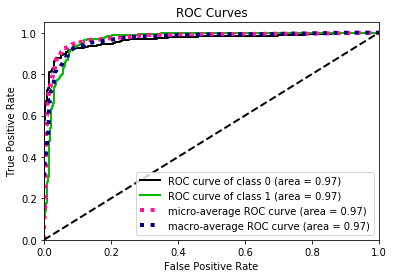

In [76]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

#Calculate Precision, Recall, Accuracy, F1, Confusion Matrix, ROC
print("Accuracy: ", accuracy_score(y_cross, y_cross_pred))
print(classification_report(y_cross ,y_cross_pred, target_names=existing_classes))

cnf_matrix = confusion_matrix(y_cross, y_cross_pred, labels=d)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
matrixSize = len(y_classes)*2
plt.figure(figsize=(matrixSize, matrixSize))
_ = vis.plot_confusion_matrix_multiclass(cnf_matrix, classes=existing_classes, title='Confusion matrix with normalization', normalize=True)
plt.show()

plt.figure(figsize=(12, 8))
print("Plot ROC curve")
_ = skplt.metrics.plot_roc(np.array(y_cross), np.array(y_cross_pred_proba))
plt.show()

#### Precision/Recall Adjustments
The optimum between precision and recall is calculated and automatically adjusted

In [77]:
# Create adjusted precision-recall curves
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [78]:
def precision_recall_threshold(y_scores, y_test, p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, step='post', alpha=0.2, color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k', markersize=15)
    plt.show()

In [79]:
#https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, optimal_threshold):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    close_default_clf = np.argmin(np.abs(thresholds - optimal_threshold))
    plt.plot(optimal_threshold, precisions[close_default_clf], 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="Optimal threshold")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [80]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

precision, recall, thresholds = precision_recall_curve(y_cross, y_cross_pred_scores)
#custom_threshold = 0.25

#Get the optimal threshold
closest_zero_index = np.argmin(np.abs(precision-recall))
optimal_threshold = thresholds[closest_zero_index]
closest_zero_p = precision[closest_zero_index]
closest_zero_r = recall[closest_zero_index]

print("Optimal threshold value = {0:.2f}".format(optimal_threshold))

Optimal threshold value = 0.14


In [81]:
%%skip $is_multiclass #skip if the problem is a multiclass problem
y_cross_pred_roc_adjusted = adjusted_classes(y_cross_pred_scores, optimal_threshold) #(y_cross_pred_scores>=optimal_threshold).astype('int')

     pred_neg  pred_pos
neg       365        44
pos        44       777


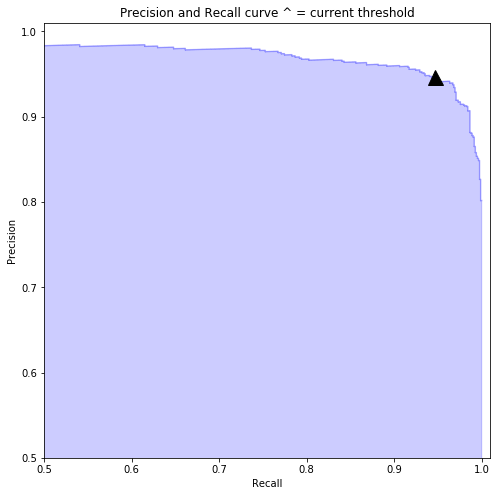

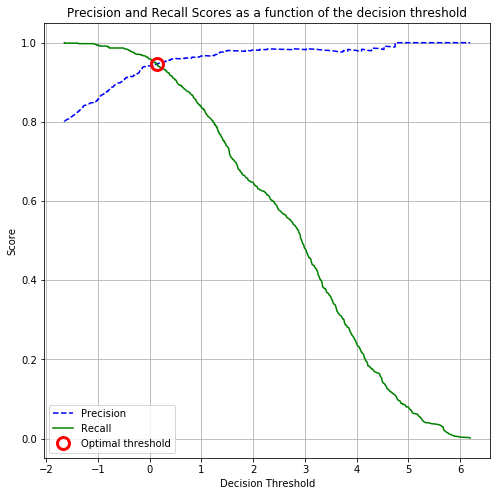

Optimal threshold value = 0.14


In [82]:
%%skip $is_multiclass #skip if the problem is a multiclass problem
precision_recall_threshold(y_cross_pred_scores, y_cross, precision, recall, thresholds, optimal_threshold)
plot_precision_recall_vs_threshold(precision, recall, thresholds, optimal_threshold)
print("Optimal threshold value = {0:.2f}".format(optimal_threshold))

In [83]:
#https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    plt.show()

AUC without P/R adjustments:  0.9666248745491961


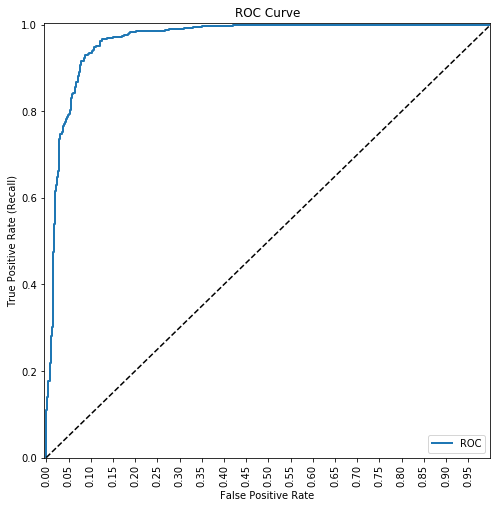

In [84]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

from sklearn.metrics import roc_curve, auc

fpr, tpr, auc_thresholds = roc_curve(y_cross, y_cross_pred_scores)
print("AUC without P/R adjustments: ", auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, label='ROC')

AUC with P/R adjustments:  0.9194136794236857


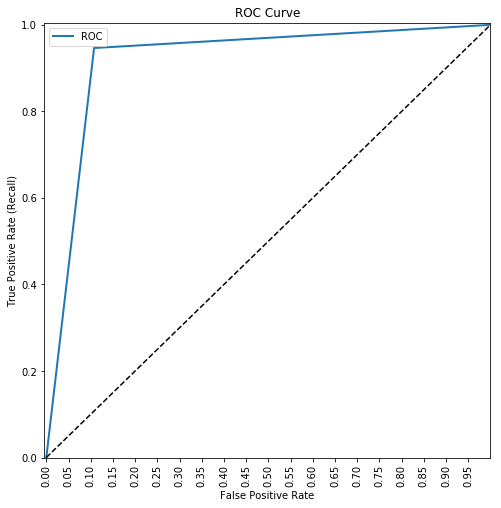

In [85]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

fpr, tpr, auc_thresholds = roc_curve(y_cross, y_cross_pred_roc_adjusted)
print("AUC with P/R adjustments: ", auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, label='ROC')

In [86]:
#precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_scores)
#closest_zero = np.argmin(np.abs(thresholds))
#closest_zero_p = precision[closest_zero]
#closest_zero_r = recall[closest_zero]

#plt.figure()
#plt.xlim([0.0, 1.01])
#plt.ylim([0.0, 1.01])
#plt.plot(precision, recall, label='Precision-Recall Curve')
#plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
#plt.xlabel('Precision', fontsize=16)
#plt.ylabel('Recall', fontsize=16)
#plt.title("Precision/Recall curve")
#plt.axes().set_aspect('equal')
#plt.gca().set_aspect('equal')
#print("closest precision={}, clostest recall={}".format(closest_zero_p, closest_zero_r))
#plt.show()

#Adjust precision
#optimalRocValue = thresholds[closest_zero]
#print("Optimal threshold=", optimalRocValue)

#Calculate new classification for cross_validation
#y_test_pred_roc_adjusted = (y_test_pred_scores>=optimal_threshold).astype('int')
#display(y_test_pred_scores)
#display(y_test_pred_roc_adjusted)

In [87]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

print("Classification report without threshold adjustment.")
print(classification_report(y_cross, y_cross_pred, target_names=existing_classes))
print("=========================================================")
print("Classification report with threshold adjustment of {0:.4f}".format(optimal_threshold))
print(classification_report(y_cross, y_cross_pred_roc_adjusted, target_names=existing_classes))

Classification report without threshold adjustment.
              precision    recall  f1-score   support

    Negative       0.91      0.88      0.90       409
    Positive       0.94      0.96      0.95       821

    accuracy                           0.93      1230
   macro avg       0.93      0.92      0.92      1230
weighted avg       0.93      0.93      0.93      1230

Classification report with threshold adjustment of 0.1363
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89       409
    Positive       0.95      0.95      0.95       821

    accuracy                           0.93      1230
   macro avg       0.92      0.92      0.92      1230
weighted avg       0.93      0.93      0.93      1230



In [88]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

# Summarize optimal results
print("Optimal score threshold: {0:.2f}".format(optimal_threshold))

Optimal score threshold: 0.14


# Train the model with optimal values for Validation
Train the model on the whole training data set nd include optimal precision-recall shift. Validate the model on the test data. This will be the final model.

In [89]:
# Train an SVM
from sklearn import svm
import time

number_of_samples = 1000000

display(param_final)
pipe_final = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel, probability=True))
        ])

display(pipe_final)

t=time.time()
local_time = time.ctime(t)
print("=== Start training the SVM at {} ===".format(local_time))

results, gridsearch_final = grid_search_for_results(X_train, y_train, pipe_final, param_final, number_of_samples=number_of_samples, kfold=10)

#optclf = svm.SVC(probability=True, C=0.5, gamma=1, kernel='rbf', verbose=True)
#optclf = gridsearch_run2#svm.SVC(probability=True, C=564, gamma=0.013, kernel='rbf', verbose=True)
#optclf.fit(X_train_shuffled.iloc[X_train_index_subset,:].values, y_train_shuffled[X_train_index_subset])
elapsed = time.time() - t
print("Training took {}s".format(elapsed))
print("Training finished")

{'svm__C': [4.895467982642922], 'svm__gamma': [7.525818386930191]}

Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

=== Start training the SVM at Wed Dec 18 12:22:01 2019 ===
Original size X:  (6149, 127)
Original size y:  (6149,)
Subset size X:  (6149, 127)
Subset size y:  (6149,)
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    5.5s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.0s finished


Final score is:  0.8772043932076647
Bets estimator:  Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=4.895467982642922, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=7.525818386930191, kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.0

In [90]:
# Calculate the 
optclf = gridsearch_final.best_estimator_

print("Predict training data")
y_train_pred = optclf.predict(X_train.values)
y_train_pred_scores = optclf.decision_function(X_train.values)

print("Predict y_cross")
y_test_pred = optclf.predict(X_test.values)
print("Predict probabilities and scores")
y_test_pred_proba = optclf.predict_proba(X_test.values)
y_test_pred_scores = optclf.decision_function(X_test.values)
print('Model properties: ', optclf)

Predict training data
Predict y_cross
Predict probabilities and scores
Model properties:  Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=4.895467982642922, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=7.525818386930191, kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinki

#### Adjust output by precision/recal optimal threshold

In [91]:
#Adjust for the optimal value of precision/recall curve
print("Optimal value: ", optimal_threshold)
pr_threshold = optimal_threshold
#pr_threshold = 0.35
print("Selected threshold: ", pr_threshold)

#Set the optimal threshol in the parameters
extern_param_final = {}
extern_param_final['pr_threshold']=pr_threshold

Optimal value:  0.13628008366959077
Selected threshold:  0.13628008366959077


In [92]:
#Adjust training data for precision/recall

if is_multiclass == False:
    y_train_pred_adjust = adjusted_classes(y_train_pred_scores, pr_threshold) #(y_train_pred_scores>=pr_threshold).astype('int')
    y_test_pred_adjust = adjusted_classes(y_test_pred_scores, pr_threshold) # (y_test_pred_scores>=pr_threshold).astype('int')
    print("This is a binarized problem. Apply optimal threshold to precision/recall.")
else:
    y_train_pred_adjust = y_train_pred
    y_test_pred_adjust = y_test_pred
    print("This is a multi class problem. No adjustment of scores are made.")

This is a binarized problem. Apply optimal threshold to precision/recall.


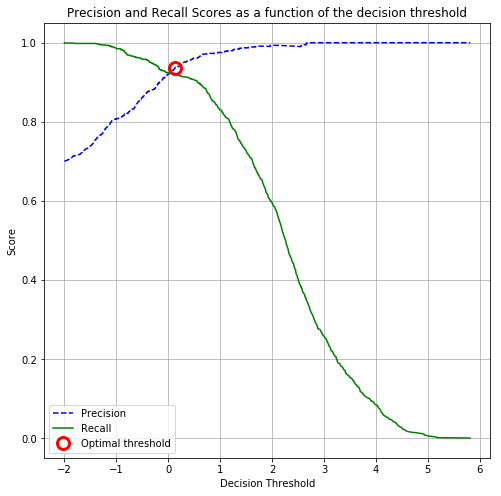

In [93]:
%%skip $is_multiclass #skip if the problem is a multiclass problem

#Plot the precision and the recall together with the selected value for the test set
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_scores)
plot_precision_recall_vs_threshold(precision, recall, thresholds, pr_threshold)

In [94]:
#Prepare the class list for classes, in case a class does not exist in the y_true and y_pred, which exist in y_train
a=np.unique(y_test)
b=np.unique(y_test_pred)
c=np.hstack((a, b))
d=np.unique(c)
existing_classes=[]
[existing_classes.append(y_classes[i]) for i in d]
existing_classes

['Negative', 'Positive']

#### Evaluate performance on Training data

In [95]:
print("Classes: ", y_classes)

Classes:  {0: 'Negative', 1: 'Positive'}


Accuracy:  0.9211253862416653
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      2046
    Positive       0.94      0.94      0.94      4103

    accuracy                           0.92      6149
   macro avg       0.91      0.91      0.91      6149
weighted avg       0.92      0.92      0.92      6149

Normalized confusion matrix
[[0.882 0.118]
 [0.059 0.941]]


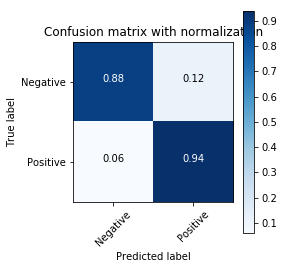

In [96]:
%matplotlib inline

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

#Calculate Precision, Recall, Accuracy, F1, Confusion Matrix, ROC
print("Accuracy: ", accuracy_score(y_train, y_train_pred_adjust))
#print(classification_report(y_train, y_train_pred_adjust, target_names=existing_classes))
print(classification_report(y_train, y_train_pred_adjust, target_names=list(y_classes.values())))

cnf_matrix = confusion_matrix(y_train, y_train_pred_adjust, labels=d)
np.set_printoptions(precision=3)

# Plot normalized confusion matrix
matrixSize = len(y_classes)*2
plt.figure(figsize=(matrixSize, matrixSize))
_ = vis.plot_confusion_matrix_multiclass(cnf_matrix, classes=existing_classes, title='Confusion matrix with normalization', normalize=True)
plt.show()

#### Evaluate performance on Test data

Accuracy:  0.9050715214564369
              precision    recall  f1-score   support

    Negative       0.84      0.87      0.85       492
    Positive       0.94      0.92      0.93      1046

    accuracy                           0.91      1538
   macro avg       0.89      0.90      0.89      1538
weighted avg       0.91      0.91      0.91      1538

Normalized confusion matrix
[[0.87  0.13 ]
 [0.078 0.922]]


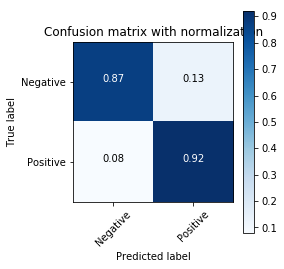

Plot ROC curve


<Figure size 864x576 with 0 Axes>

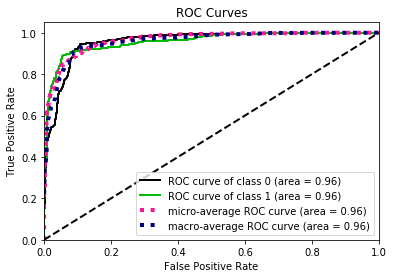

In [97]:
#Calculate Precision, Recall, Accuracy, F1, Confusion Matrix, ROC
print("Accuracy: ", accuracy_score(y_test, y_test_pred_adjust))
print(classification_report(y_test ,y_test_pred_adjust, target_names=existing_classes))

cnf_matrix = confusion_matrix(y_test, y_test_pred_adjust, labels=d)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
matrixSize = len(y_classes)*2
plt.figure(figsize=(matrixSize, matrixSize))
_ = vis.plot_confusion_matrix_multiclass(cnf_matrix, classes=existing_classes, title='Confusion matrix with normalization', normalize=True)
plt.show()

plt.figure(figsize=(12, 8))
print("Plot ROC curve")
_ = skplt.metrics.plot_roc(np.array(y_test), np.array(y_test_pred_proba))
plt.show()

#### Decision Boundary Plot

(1000, 2)


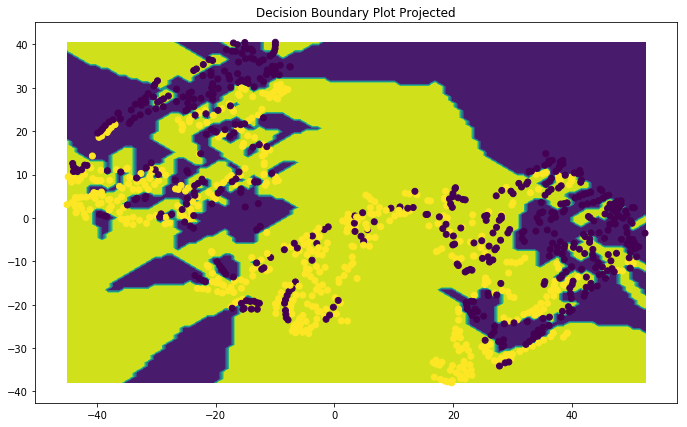

In [98]:
%matplotlib inline

import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.datasets.base import load_iris
from sklearn.manifold.t_sne import TSNE
from sklearn.linear_model.logistic import LogisticRegression

# replace the below by your data and model
#iris = load_iris()
#X,y = iris.data, iris.target
X_decision=X_train.values[0:1000,:]
y_decision=y_train[0:1000]
X_Train_embedded = TSNE(n_components=2).fit_transform(X_decision)
print(X_Train_embedded.shape)
#model = LogisticRegression().fit(X,y)
model = optclf
y_predicted = model.predict(X_decision)
# replace the above by your data and model

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.figure(figsize=(11.5, 7))
plt.contourf(xx, yy, voronoiBackground)
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_decision)
plt.title("Decision Boundary Plot Projected")
plt.show()

## Visualize Results

#### Viualize the results compared to the initial results

In [99]:
#Load original data for visualization
import matplotlib.dates as mdates
import datetime
filename_timegraph = filedataresultdirectory + "/" + filenameprefix + "_timegraph" + ".csv"

df_timegraph = pd.read_csv(filename_timegraph, delimiter=';').set_index('id')
df_timegraph['Time'] = pd.to_datetime(df_timegraph['Time'])
df_timegraph['Time'].apply(mdates.date2num)
print("Loaded feature names for time graph={}".format(df_timegraph.columns))
print("X. Shape={}".format(df_timegraph.shape))
display(df_timegraph.head())

Loaded feature names for time graph=Index(['Time', 'High', 'Low', 'Close'], dtype='object')
X. Shape=(7687, 4)


,Time,High,Low,Close
id,,,,
400,1988-05-09,129.71,129.71,129.71
401,1988-05-10,129.84,129.84,129.84
402,1988-05-11,128.78,128.78,128.78
403,1988-05-13,128.66,128.66,128.66
404,1988-05-16,129.95,129.95,129.95


In [100]:
#Map the X_train indices to y_train again to get the correct y.

#X_train.iloc[0:10,:]
#Create a df from the y array
y_order_train = pd.DataFrame(index=X_train.index, data=pd.Series(data=y_train, index=X_train.index, name="y")).sort_index()
#display(y_order_train[0:10])
#print(y_order_train.size)

y_order_train_pred = pd.DataFrame(index=X_train.index, data=pd.Series(data=y_train_pred_adjust, index=X_train.index, name="y")).sort_index()
#display(y_order_train_pred[0:10])
#print(y_order_train_pred.size)

y_order_test = pd.DataFrame(index=X_test.index, data=pd.Series(data=y_test, index=X_test.index, name="y")).sort_index()

y_order_test_pred = pd.DataFrame(index=X_test.index, data=pd.Series(data=y_test_pred_adjust, index=X_test.index, name="y")).sort_index()

In [101]:
#def amplifyForPlot(binaryArray, targetArray, distance):
#    return binaryArray * targetArray * (1-distance)

%matplotlib notebook

def plot_three_class_graph(y_class, y_ref, y_time, offset1, offset2, offset3, legend):
    
    y0 = (y_class==0)*1
    y1 = (y_class==1)*1
    y2 = (y_class==2)*1
    
    plot_data_OK = amplifyForPlot(y0, y_ref, offset1)
    plot_data_blim = amplifyForPlot(y1, y_ref, offset2)
    plot_data_tlim = amplifyForPlot(y2, y_ref, offset3)
    
    # Plot test data
    plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(y_time, y_ref)
    plt.plot(y_time, plot_data_OK, color='grey')
    plt.plot(y_time, plot_data_blim, color='green')
    plt.plot(y_time, plot_data_tlim, color='red')
    plt.title("Prediction Results")
    plt.ylim([np.min(y_ref)*0.99999, np.max(y_ref)*1.00002])
    plt.grid()
    plt.legend(legend)
    plt.show()

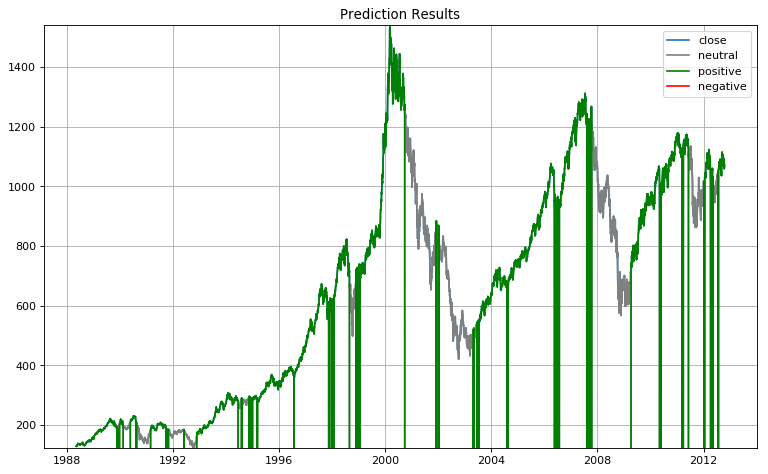

In [102]:
#Present long term term data

vis.plot_three_class_graph(y_order_train_pred['y'].values, 
                       df_timegraph['Close'][y_order_train.index], 
                       df_timegraph['Time'][y_order_train.index], 0,0,0,('close', 'neutral', 'positive', 'negative'))

<IPython.core.display.Javascript object>


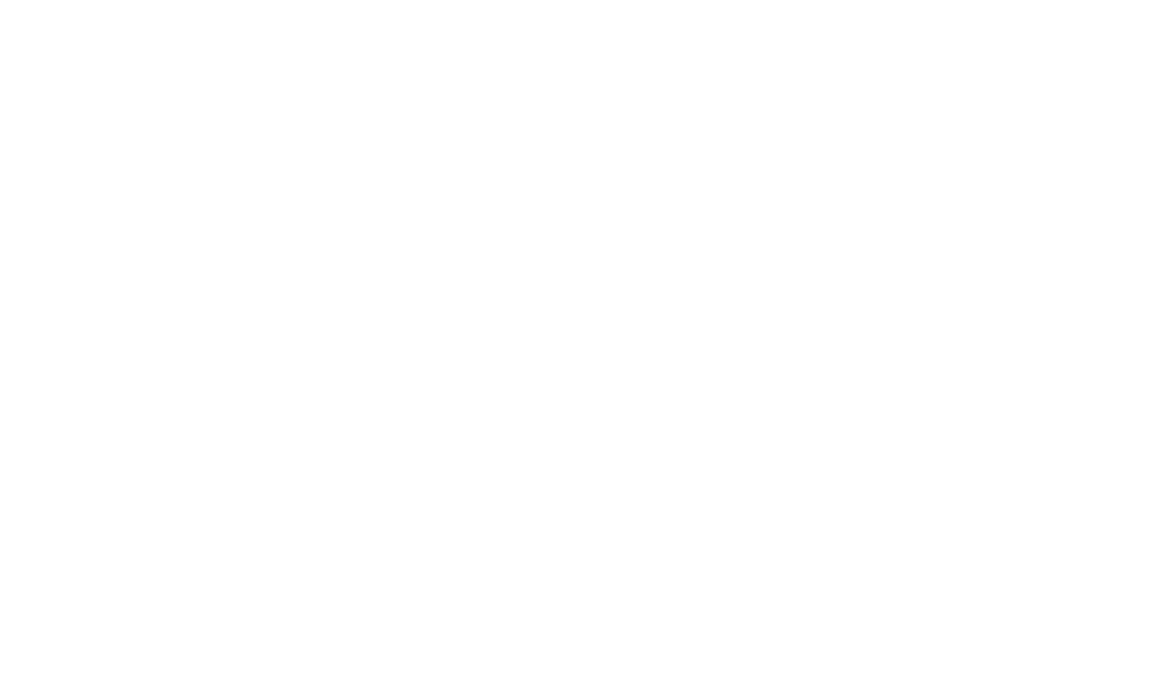

<IPython.core.display.Javascript object>


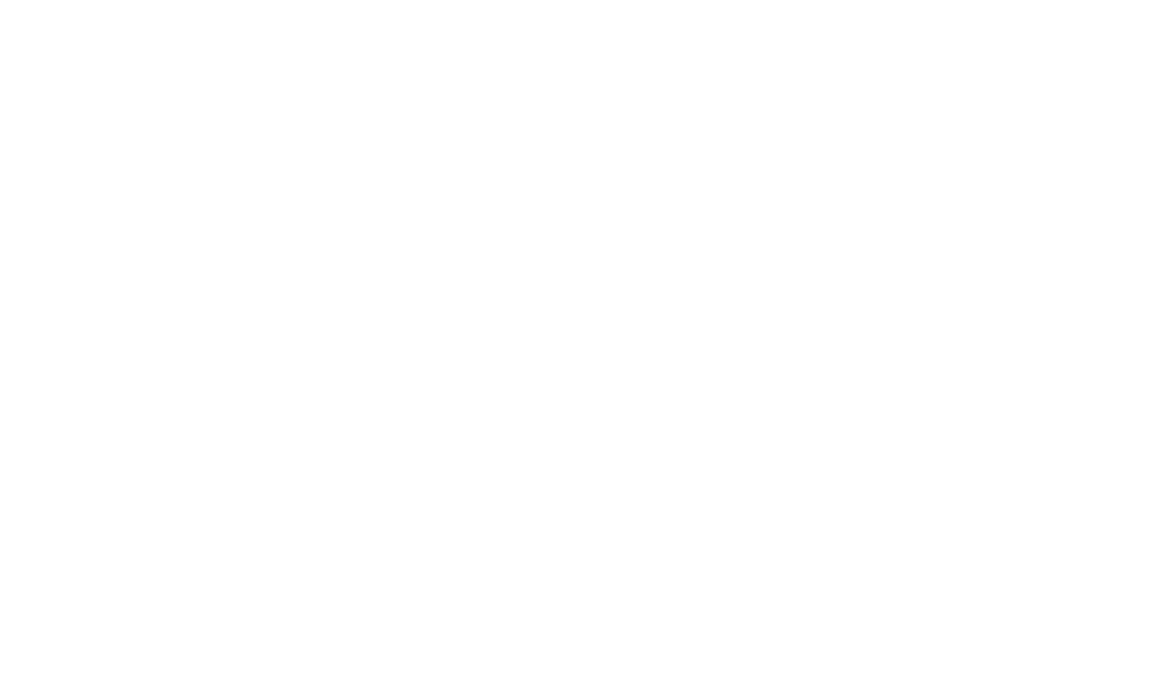

In [103]:
%matplotlib notebook

# Plot training data
# Load graph for Borsdata


plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')
#plt.plot(df_timegraph['Time'],df_timegraph['Close'])
#plt.plot(df_timegraph['Time'],amplifyForPlot(y, df_timegraph['Close'].values, 0.00), color='green')

plt.plot(df_timegraph['Time'][y_order_train.index],df_timegraph['Close'][y_order_train.index])
plt.plot(df_timegraph['Time'][y_order_train.index],vis.amplifyForPlot(y_order_train['y'].values, df_timegraph['Close'][y_order_train.index].values, 0.00), color='green')
plt.plot(df_timegraph['Time'][y_order_train.index],vis.amplifyForPlot(y_order_train_pred['y'].values, df_timegraph['Close'][y_order_train.index].values, 0.00), color='yellow')
plt.title("Plot results")
plt.show()

<IPython.core.display.Javascript object>


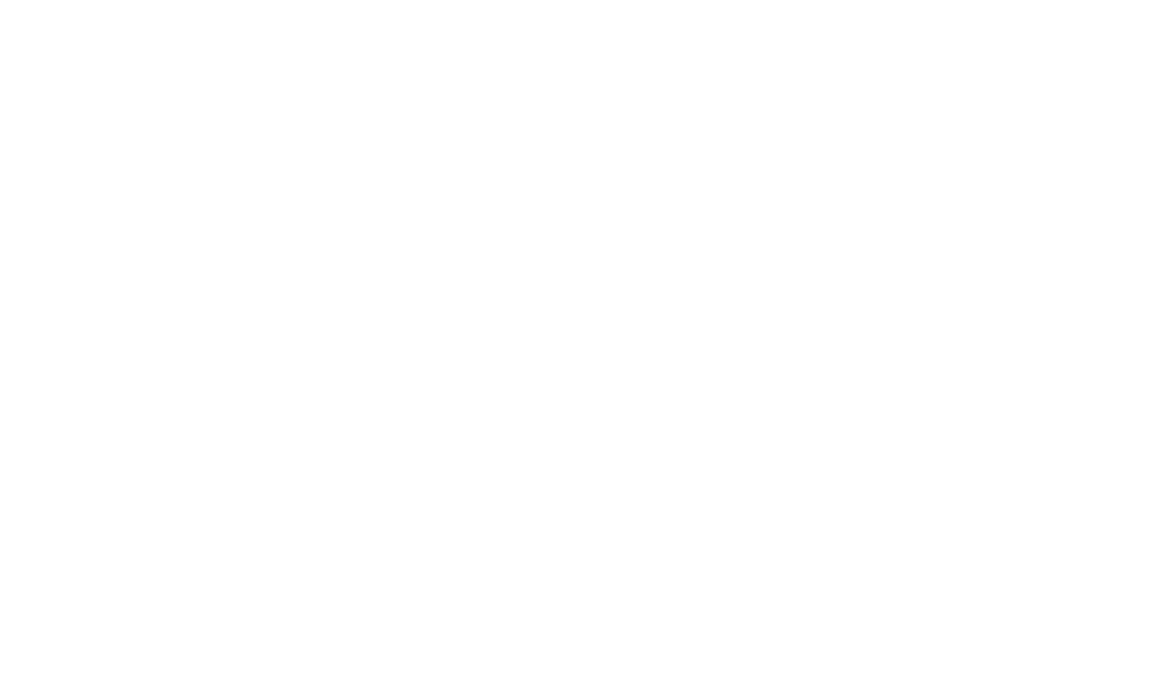

<IPython.core.display.Javascript object>


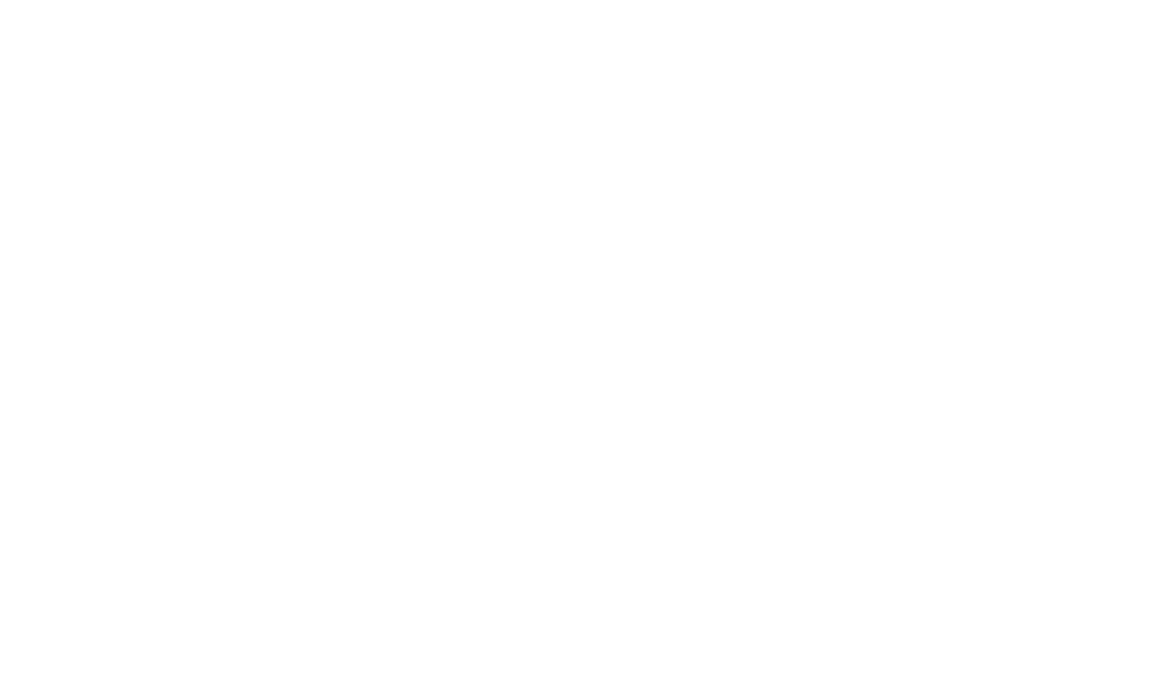

In [104]:
#Present long term term data
vis.plot_three_class_graph(y_order_test_pred['y'].values, 
                       df_timegraph['Close'][y_order_test.index], 
                       df_timegraph['Time'][y_order_test.index], 0,0,0,('close', 'neutral', 'positive', 'negative'))

<IPython.core.display.Javascript object>


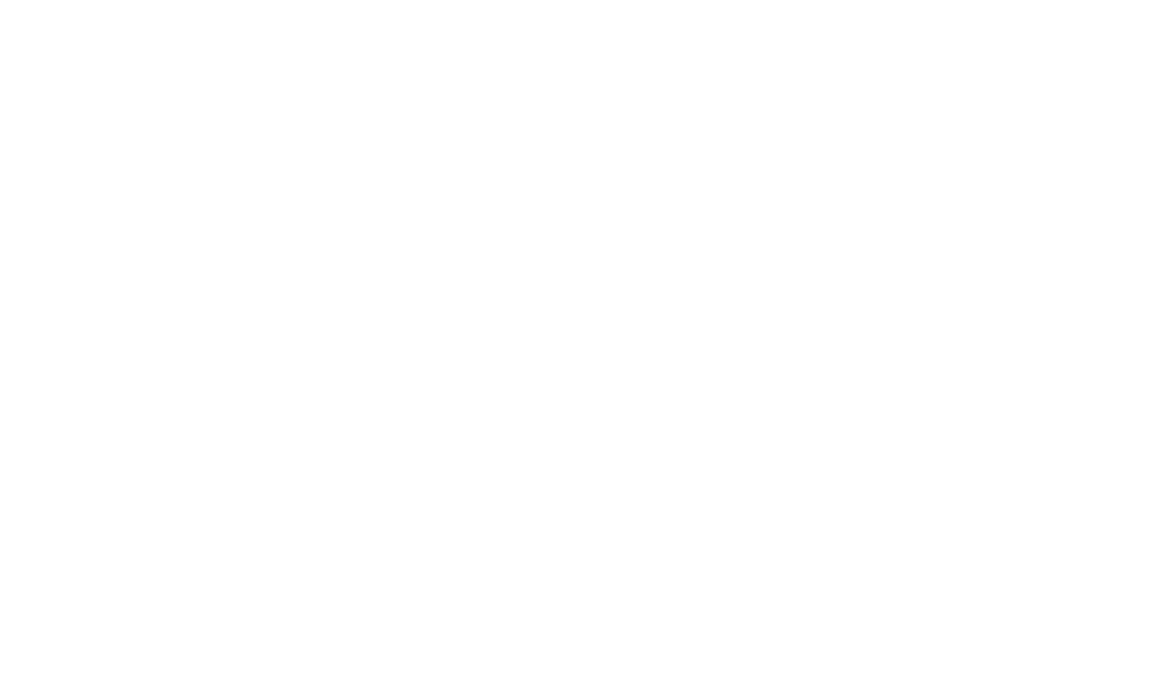

<IPython.core.display.Javascript object>


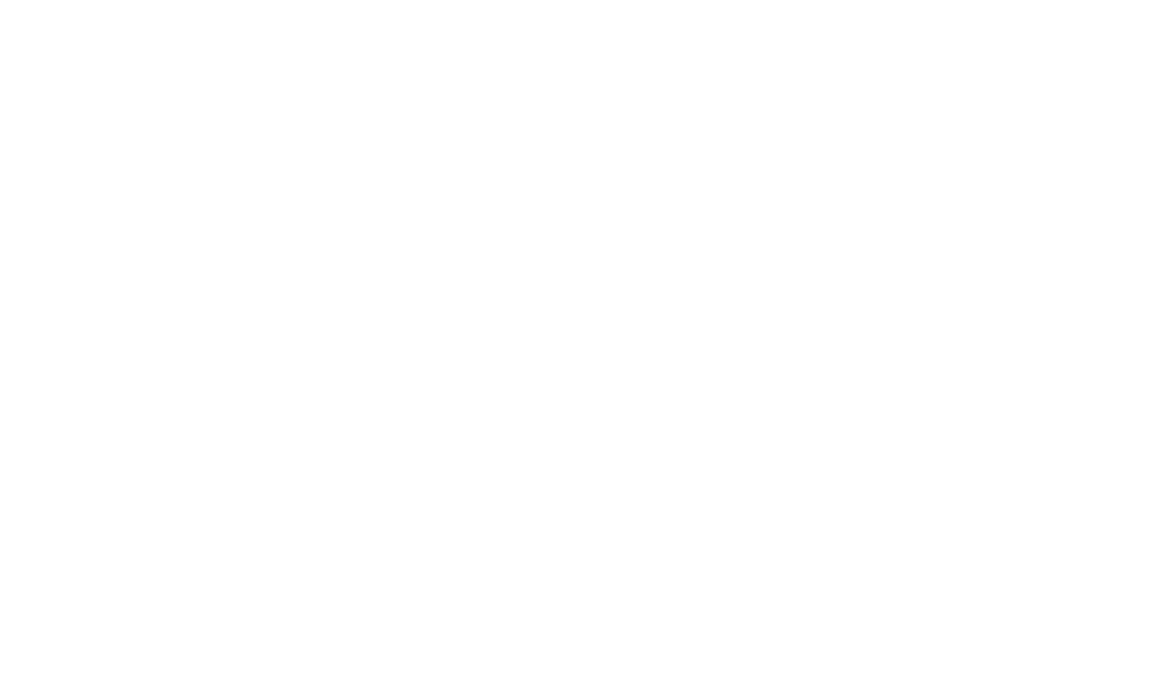

In [105]:
%matplotlib notebook

# Plot test data
plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')
#plt.plot(df_timegraph['Time'],df_timegraph['Close'])
#plt.plot(df_timegraph['Time'],amplifyForPlot(y, df_timegraph['Close'].values, 0.00), color='green')

plt.plot(df_timegraph['Time'][X_test.index],df_timegraph['Close'][X_test.index])
plt.plot(df_timegraph['Time'][X_test.index],vis.amplifyForPlot(y_order_test['y'].values, df_timegraph['Close'][X_test.index].values, 0.00), color='green')
plt.plot(df_timegraph['Time'][X_test.index],vis.amplifyForPlot(y_order_test_pred['y'].values, df_timegraph['Close'][X_test.index].values, 0.01), color='yellow')
plt.title("Plot results")
plt.show()

In [106]:
#%matplotlib notebook
# Try scores that are smoothed
#import statsmodels.api as sm
#lowess = sm.nonparametric.lowess
#y_cross_pred_scores
#z = lowess(y_cross_pred_scores, range(len(y_cross_pred_scores)))

# Plot test data
#plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')
#plt.plot(df_timegraph['Time'],df_timegraph['Close'])
#plt.plot(df_timegraph['Time'],amplifyForPlot(y, df_timegraph['Close'].values, 0.00), color='green')
#d = (z[:, 1]>=0).astype('int')

#plt.plot(df_timegraph['Time'][X_cross.index],df_timegraph['Close'][X_cross.index])
#plt.plot(df_timegraph['Time'][X_cross.index],amplifyForPlot(y_cross.flatten(), df_timegraph['Close'][X_cross.index].values, 0.00), color='green')
#plt.plot(df_timegraph['Time'][X_cross.index],amplifyForPlot(d, df_timegraph['Close'][X_cross.index].values, 0.00), color='yellow')
#plt.title("Plot results")
#plt.show()



In [107]:
# Plot the results of unknown data

# Train Complete Model With Optimal Parameters
- Train system with all data and best parameters
- Save the model with parameters

In [108]:
# Train an SVM
from sklearn import svm
import time

number_of_samples = 1000000
kfold=10

display(param_final)
pipe_final = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel, probability=True))
        ])

display(pipe_final)
print("Optimal precision/recall threshold: {}".format(pr_threshold))

t=time.time()
local_time = time.ctime(t)
print("=== Start training the SVM at {} ===".format(local_time))

results, gridsearch_final = grid_search_for_results(df_X, y, pipe_final, param_final, number_of_samples=number_of_samples, kfold=kfold)

finalclf = gridsearch_final.best_estimator_

elapsed = time.time() - t
print("Training took {}s".format(elapsed))
print("Training finished")

{'svm__C': [4.895467982642922], 'svm__gamma': [7.525818386930191]}

Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Optimal precision/recall threshold: 0.13628008366959077
=== Start training the SVM at Wed Dec 18 12:22:20 2019 ===
Original size X:  (7687, 127)
Original size y:  (7687,)
Subset size X:  (7687, 127)
Subset size y:  (7687,)
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    9.0s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    9.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished


Final score is:  0.8948232236887095
Bets estimator:  Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=4.895467982642922, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=7.525818386930191, kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.0

In [109]:
#Save the model
import joblib
import json

# save the optimal precision/recall value to disk
print("Save external parameters, precision recall threshold to disk")
with open(external_parameters_filename, 'w') as fp:
    json.dump(extern_param_final, fp)
print("Saved external parameters to disk: ", external_parameters_filename)
#with open(external_parameters_filename, "w") as f:
#    #for s in score:
#    f.write(str(pr_threshold) +"\n")

# save the model to disk
print("Model to save: ", finalclf)

joblib.dump(finalclf, model_filename)
print("Saved model at location ", model_filename)

Save external parameters, precision recall threshold to disk
Saved external parameters to disk:  04_Model/omxs30_LongTrend_final_model_ext_parameters.json
Model to save:  Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=4.895467982642922, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=7.525818386930191, kernel='linear

In [110]:
#Run all above for model training

# Debug and Experiment

#Test if the result of two classifiers differ significatly

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import paired_ttest_kfold_cv


#X, y = iris_data()
clf1 = LogisticRegression(random_state=1)
clf2 = DecisionTreeClassifier(random_state=1)

#X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.25,
#                     random_state=123)

score1 = clf1.fit(X_train, y_train).score(X_cross, y_cross)
score2 = clf2.fit(X_train, y_train).score(X_cross, y_cross)

print('Logistic regression accuracy: %.2f%%' % (score1*100))
print('Decision tree accuracy: %.2f%%' % (score2*100))

t, p = paired_ttest_kfold_cv(estimator1=clf1, estimator2=clf2, X=X_train, y=y_train, random_seed=0)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)
#Since p>t, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.
if p>t:
    print("p>t: We cannot reject the null hypothesis, i.e. that the performance of the algorithms differ significantly")
else:
    print("p<t: The performance of the algorithms differ significantly")

from scipy.stats import expon 

# Random Variates 
R = expon.rvs(loc=0, scale = 100, size=100) 
print ("Random Variates : \n", R) 

#C = uniform.rvs(loc=0.001, scale=10, size=100)
#print(C)

# Test SMOTE on set
#https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn

from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(X_train_res.shape)
print(X_train.shape)

gridsearch_run2.cv_results_['mean_train_f1_micro_score']
gridsearch_run2.cv_results_

def plot_grid_search_validation_curve(grid, param_to_vary, title='Validation Curve', ylim=None, xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""
    #https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_f1_micro_score']
    valid_scores_mean = df_cv_results['mean_test_f1_micro_score']
    train_scores_std = df_cv_results['std_train_f1_micro_score']
    valid_scores_std = df_cv_results['std_test_f1_micro_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.figure(figsize=(5,5))
    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    #if (not isinstance(param_range[0], numbers.Number)):
    #    param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    plt.legend(loc='lower right')

    plt.show()

plot_grid_search_validation_curve(gridsearch_run2, 'svm__C', log=True, ylim=(0.80, 1.01))
plot_grid_search_validation_curve(gridsearch_run2, 'svm__gamma', log=True, ylim=(0.80, 1.01))

from matplotlib import pyplot as PLT
from matplotlib import cm as CM
from matplotlib import mlab as ML
import numpy as NP

n = 1e5
x = y = NP.linspace(-5, 5, 100)
X, Y = NP.meshgrid(x, y)
Z1 = ML.bivariate_normal(X, Y, 2, 2, 0, 0)
Z2 = ML.bivariate_normal(X, Y, 4, 1, 1, 1)
ZD = Z2 - Z1
x = X.ravel()
y = Y.ravel()
z = ZD.ravel()
gridsize=30
PLT.subplot(111)
# if 'bins=None', then color of each hexagon corresponds directly to its count
# 'C' is optional--it maps values to x-y coordinates; if 'C' is None (default) then 
# the result is a pure 2D histogram 

PLT.hexbin(x, y, C=z, gridsize=gridsize, cmap=CM.jet, bins=None)
PLT.axis([x.min(), x.max(), y.min(), y.max()])

cb = PLT.colorbar()
cb.set_label('mean value')
PLT.show()   

def plot_heat_from_rand_xy(scores, parameters, xlabel, ylabel, title, normalizeScale=False):
    # Source of inspiration: https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html

    #Plot a heatmap of 2 variables
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True, sharey=True)
    colorMap = plt.cm.bone #plt.cm.gist_gray #plt.cm.hot
    
    if normalizeScale==True:
        im1 = plt.imshow(scores, interpolation='catrom', cmap=colorMap, vmin=0 , vmax=1)
    else:
        #im1 = plt.imshow(scores, interpolation='nearest', cmap=colorMap)
        im1 = plt.imshow(scores, interpolation='catrom', origin='lower', cmap=colorMap)

    levels = np.linspace(np.min(scores), np.max(scores), 20)
        
   # contours = plt.contour(scores, 10, colors='black')
    #contours = plt.contour(scores, 10, colors='black')
    contours = ax.contourf(scores, levels=levels, cmap=plt.cm.bone)
    
    ax.contour(scores, levels=levels, colors='k', linestyles='solid', alpha=1, linewidths=.5, antialiased=True)
    
    #plt.contourf = 
    ax.clabel(contours, inline=True, fontsize=8, colors='r')    
    
    #Get best value
    def get_Top_n_values_from_array(arr, n):
        result = []
        for i in range(1,n+1):
            x = np.partition(arr.flatten(), -2)[-i]
            r = np.where(arr == x)
            #print(r[0][0], r[1][0])
            value = [r[0][0], r[1][0]]
            result.append(value)
        return result
    
    bestvalues = get_Top_n_values_from_array(scores, 10)
    [plt.plot(pos[1], pos[0], 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="best_value") for pos in bestvalues]
    #best = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
    #print(best)
    #plt.plot(parameters[xlabel][best[1]], parameters[ylabel][best[0]], 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="value1")
    #plt.plot(3, 8, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3, label="value1")
    
    plt.sca(ax)
    plt.xticks(np.arange(len(parameters[xlabel])), ['{:.1E}'.format(x) for x in parameters[xlabel]], rotation='vertical')
    plt.yticks(np.arange(len(parameters[ylabel])), ['{:.1E}'.format(x) for x in parameters[ylabel]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, len(parameters[xlabel])-1)
    plt.ylim(0, len(parameters[ylabel])-1)
    ax.set_title(title)
    
    #cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.8])
    cbar = fig.colorbar(im1, ax=ax) #cax=axs[1])
    plt.show()
    
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    points = np.array([x, y]).T
    Z = griddata(x, y, z, xi, yi, interp='linear')
    #print(len(Z))
    #print(len(points))
    X, Y = meshgrid(xi, yi)
    return X, Y, Z
    
scores = gridsearch_run2.cv_results_['mean_test_' + refit_scorer_name][indexes].reshape(len(params_run2['svm__C']), len(params_run2['svm__gamma']))
print(scores)
print(params_run2)

X, Y, Z = grid(x.data, y.data, cols)
print(X[0])
print(Z)

plot_heat_from_rand_xy(scores, params_run2, 'svm__gamma', 'svm__C', 'F1 score, kernel=rbf')

np.random.seed(0)
npts = 200
ngridx = 100
ngridy = 200
x = np.random.uniform(-2, 2, npts)
y = np.random.uniform(-2, 2, npts)
z = x * np.exp(-x**2 - y**2)

# griddata and contour.
#start = time.clock()
plt.subplot(211)
xi = np.linspace(-2.1, 2.1, ngridx)
yi = np.linspace(-2.1, 2.1, ngridy)
zi = mlab.griddata(x, y, z, xi, yi, interp='linear')

#len(np.array(y).astype(np.float)[0:100])
#x1
#len(np.array(x).astype(np.float)[0:100])
x.shape

x2 = np.array(x)[0:200]
y2 = np.array(y)[0:200]
x2.shape

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed

# make up some randomly distributed data
seed(1234)
#npts = 200
#x = uniform(-2,2,npts)
#y = uniform(-2,2,npts)
#z = x*np.exp(-x**2-y**2)
z=cols
# define grid.
#xi = np.linspace(-2.1,2.1,100)
#yi = np.linspace(-2.1,2.1,100)
resX=100
resY=100
xi = np.linspace(min(x), max(x), resX)
yi = np.linspace(min(y), max(y), resY)
# grid the data.
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.bone)
plt.colorbar() # draw colorbar
#plt.xscale('log')
#plt.yscale('log')
# plot data points.
#plt.scatter(x,y,marker='o',c='b',s=5)
#plt.xlim(min(np.log(x)),max(np.log(x)))
#plt.xlim(1e1,1e4)
#plt.ylim(1e-1,1e1)
plt.title('griddata test (%d points)' % npts)
plt.show()

points = np.random.rand(1000, 2)
points
s = np.array([x.data, y.data]).T
s



from numpy import linspace, meshgrid
from matplotlib.mlab import griddata
from matplotlib import ticker, cm
#from scipy.interpolate import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    points = np.array([x, y]).T
    Z = griddata(x, y, z, xi, yi, interp='linear')
    #print(len(Z))
    #print(len(points))
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

X, Y, Z = grid(x.data, y.data, cols)
print(Z.shape)
print(Z)
print(X.shape)
print(Y.shape)
ax = plt.contourf(X, Y, Z, cmap=plt.cm.bone)
plt.colorbar()

10000 training examples need 63s. 20000 examples need 240s. Conclusion: Time inceases ^2 with increasing number of examples 

#Visualize
from matplotlib.ticker import FuncFormatter

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return '%1f' % (x)

score_table = results[['mean_test_f1_micro_score', 'param_C', 'param_gamma']].round(3)
score_table

fig = plt.figure(figsize=(8,5))
ax = plt.gca()
ax.scatter(score_table['param_C'], score_table['param_gamma'], c=score_table['mean_test_f1_micro_score'], cmap=plt.cm.hot)
ax.set_xscale('log')
ax.set_yscale('log')
formatter = FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim(1e1, 1e3+200)
ax.set_ylim(1e-5, 1.5)
ax.set_xlabel("C")
ax.set_ylabel("gamma")


## Normalize Data
Z-Normalize the data around zero and divided by standard deviation. Fit the normalizer on the training data and transform the training and the test data. The reason is that the scaler only must depend on the training data, in order to prevent leakage of information from the test data.

from sklearn import preprocessing

#=== Select the best type of scaler ===#
scaler = preprocessing.StandardScaler()  #Normal distributed data
#scaler = preprocessing.MinMaxScaler()

scaler.fit(X_train_unscaled)
#Use this scaler also for the test data at the end
X_train = pd.DataFrame(data=scaler.transform(X_train_unscaled), index = X_train_unscaled.index, columns=X_train_unscaled.columns)
print("Unscaled values")
display(X_train_unscaled.iloc[0:2,:])
print("Scaled values")
display(X_train.iloc[0:2,:])

X_cross = pd.DataFrame(data=scaler.transform(X_cross_unscaled), index = X_cross_unscaled.index, columns=X_cross_unscaled.columns)
print("Unscaled values")
display(X_cross_unscaled.iloc[0:2,:])
print("Scaled values")
display(X_cross.iloc[0:2,:])

#=== Shuffle the training data to get random training of the SVM ===
from sklearn.utils import shuffle

X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
print("Unschuffled X,y data")
display(X_train.head())
display(y_train[0:5])
print("Schuffled X,y data")
display(X_train_shuffled.head())
display(y_train_shuffled[0:5])
print("A list of shuffled x values created")

#Test that split is ok
value = X_train.iloc[2].name
idx = X_train_shuffled.index.get_loc(value)
y_train_shuffled[idx]

### Bayesian Optimization of Parameters 1

params_run_bayes = { 
        'svm__C': reciprocal(parameter_svm.loc['param_svm__C']['min'], parameter_svm.loc['param_svm__C']['max']), 
        'svm__gamma': reciprocal(parameter_svm.loc['param_svm__gamma']['min'], parameter_svm.loc['param_svm__gamma']['max'])
        }

params_debug = {
        'svm__C': (0.1, 10, 'log-uniform'), 
        'svm__gamma': (0.1, 10, 'log-uniform')
        }

pipe_run_random = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel))
        ])

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC

# http://blairhudson.com/blog/posts/optimising-hyper-parameters-efficiently-with-scikit-optimize/
# https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html
# https://github.com/scikit-optimize/scikit-optimize/issues/762


# we're using a logistic regression model
#clf = LogisticRegression(random_state=1234, verbose=0)

# this is our parameter grid
#param_grid = {
#    'solver': ['liblinear', 'saga'],  
#    'penalty': ['l1','l2'],
#    'tol': (1e-5, 1e-3, 'log-uniform'),
#    'C': (1e-5, 100, 'log-uniform'),
#    'fit_intercept': [True, False]
#}

pipe = Pipeline([
    ('model', SVC())
])

svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-1, 1e+1, prior='log-uniform'),
    'model__gamma': Real(1e-1, 1e+1, prior='log-uniform'),
    #'model__degree': Integer(1,8),
    #'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

# set up our optimiser to find the best params in 30 searches
opt = BayesSearchCV(pipe, svc_search, n_iter=20, cv=3)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

### Bayesian Optimization of Parameters
Use Hyperopt to find the best parameters for the MLP regressor
Guide: https://blog.goodaudience.com/on-using-hyperopt-advanced-machine-learning-a2dde2ccece7

from hyperopt import tpe, hp, fmin
from sklearn.svm import SVC

#Define pipeline, which is constant for all tests
pipe_run_random = Pipeline([
        ('scaler', best_scaler),
        ('sampling', best_sampler),
        ('feat', ColumnExtractor(cols=best_columns)),
        ('svm', SVC(kernel=best_kernel))
        ])


def objective_func(args):
    if args['model']==SVC:
        C = args['param']['C']
        gamma = args['param']['gamma']
        #solver = args['param']['solver']
        #alpha = args['param']['alpha']
        #learning_rate = args['param']['learning_rate']
        #max_iter = args['param']['max_iter']
        clf = SVC(C=C, gamma=gamma)

    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    loss = cross_val_score(clf, X_train, y_train_pred).mean()
    #print("Test Score:",clf.score(X_cross.values, y_cross.values.flatten()))
    #print("Train Score:",clf.score(X_train.iloc[X_train_index_subset,:].values, y_train.values.flatten()[X_train_index_subset]))
    #print("\n=================")
    return loss

#parameters = {
#    'hidden_layer_sizes': [(100,), (500,), (700,), (100, 100), (500,500), (100,500), (50,100,50), (100,100,50), (100,100,100)],
#    'activation': ['tanh', 'relu'],
#    'solver': ['sgd', 'adam', 'lbfgs'],
#    'alpha': [0.0001, 0.01, 1, 100, 1000],
#    'learning_rate': ['constant','adaptive'],
#}


space = hp.choice('classifier',[
        #{'model': MLPRegressor,
        # 'param': {'hidden_layer_sizes': 
        #           hp.choice('hidden_layer_sizes', [(100,), (500,), (700,), (100, 100), (500,500), (100,500), (50,100,50), (100,100,50), (100,100,100)]),
        #           'activation': hp.choice('activation', ['tanh', 'relu']),
        #           'solver': hp.choice('solver', ['sgd', 'adam', 'lbfgs']),
         #          'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1e3)),
         #          'learning_rate': hp.choice('learning_rate', ['constant','adaptive']),
         #          'max_iter': hp.randint('max_iter', 10000)+200
         #         }
        #},
        {'model': SVC,
         'param':{'C':hp.loguniform('C', np.log(1e-4), np.log(1e3)),
                  #'kernel':hp.choice('kernel',['rbf','poly','rbf','sigmoid']),
                  #'degree':hp.choice('degree',range(1,15)),
                  'gamma':hp.uniform('gamma',1e-2,1e4)}
        }
        ])
#'C':hp.lognormal('C',0,1),

best_classifier = fmin(objective_func, space, algo=tpe.suggest,max_evals=10)
print("Best classifier:", best_classifier)

from hyperopt import tpe, hp, fmin
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

def objective_func(args):
    if args['model']==MLPRegressor:
        hidden_layer_sizes = args['param']['hidden_layer_sizes']
        activation = args['param']['activation']
        solver = args['param']['solver']
        alpha = args['param']['alpha']
        learning_rate = args['param']['learning_rate']
        max_iter = args['param']['max_iter']
        clf = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                           activation=activation, 
                           solver=solver, 
                           alpha=alpha, 
                           learning_rate=learning_rate, 
                           max_iter=max_iter
                          )

    clf.fit(X_train.iloc[X_train_index_subset,:].values, y_train.values.flatten()[X_train_index_subset])
    y_train_pred = clf.predict(X_train.iloc[X_train_index_subset,:].values)
    loss = mean_squared_error(y_train.values.flatten()[X_train_index_subset], y_train_pred)
    print("Test Score:",clf.score(X_cross.values, y_cross.values.flatten()))
    print("Train Score:",clf.score(X_train.iloc[X_train_index_subset,:].values, y_train.values.flatten()[X_train_index_subset]))
    print("\n=================")
    return loss

#parameters = {
#    'hidden_layer_sizes': [(100,), (500,), (700,), (100, 100), (500,500), (100,500), (50,100,50), (100,100,50), (100,100,100)],
#    'activation': ['tanh', 'relu'],
#    'solver': ['sgd', 'adam', 'lbfgs'],
#    'alpha': [0.0001, 0.01, 1, 100, 1000],
#    'learning_rate': ['constant','adaptive'],
#}


space = hp.choice('classifier',[
        {'model': MLPRegressor,
         'param': {'hidden_layer_sizes': 
                   hp.choice('hidden_layer_sizes', [(100,), (500,), (700,), (100, 100), (500,500), (100,500), (50,100,50), (100,100,50), (100,100,100)]),
                   'activation': hp.choice('activation', ['tanh', 'relu']),
                   'solver': hp.choice('solver', ['sgd', 'adam', 'lbfgs']),
                   'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1e3)),
                   'learning_rate': hp.choice('learning_rate', ['constant','adaptive']),
                   'max_iter': hp.randint('max_iter', 10000)+200
                  }
        },
        {'model': SVC,
         'param':{'C':hp.loguniform('alpha', np.log(1e-4), np.log(1e3)),
                  'kernel':hp.choice('kernel',['rbf','poly','rbf','sigmoid']),
                  'degree':hp.choice('degree',range(1,15)),
                  'gamma':hp.uniform('gamma',1e-2,1e4)}
        }
        ])
#'C':hp.lognormal('C',0,1),

best_classifier = fmin(objective_func, space, algo=tpe.suggest,max_evals=10)
print("Best classifier:", best_classifier)

### Bayesian Optimization with Visualization of the Results
Source: https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#define X
X_hyper_train = X_train.iloc[X_train_index_subset,:].values
#deine y
y_hyper_train = y_train.values.flatten()[X_train_index_subset]

def f(params):
    """object function for hyperopt"""
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

def hyperopt_train_test(params):
    """Hyperopt train test values"""
    X_ = X_hyper_train[:]
    #if 'normalize' in params:
    #    if params['normalize'] == 1:
    #        X_ = normalize(X_)
    #        del params['normalize']
    #if 'scale' in params:
    #    if params['scale'] == 1:
    #        X_ = scale(X_)
    #        del params['scale']
    clf = MLPRegressor(**params)
    return cross_val_score(clf, X_, y_hyper_train, cv=5, n_jobs=-1).mean()

#'hidden_layer_sizes': [(sp_randint.rvs(5,10,1),), (sp_randint.rvs(5,15,1),sp_randint.rvs(5,15,1))],
#'activation': ['tanh', 'relu'],
#'solver': ['sgd', 'adam'],
#'alpha': uniform(1e-4, 1e1),
#'learning_rate': ['constant','adaptive'],
#'max_iter': [500]

#Define the searchspace
#space4mlp = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(100,), (500,), (700,), (100, 100), (500,500), (100,500), (50,100,50), (100,100,50), (100,100,100)]),
#             'activation': hp.choice('activation', ['tanh', 'relu']),
#             'solver': hp.choice('solver', ['sgd', 'adam', 'lbfgs']),
#             'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1e3)),
#             'learning_rate': hp.choice('learning_rate', ['constant','adaptive']),
#             'max_iter': hp.randint('max_iter', 10000)+200
#            }

space4mlp = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(3,), (5,), (10,), (15,), (100,), (3, 3), (5,5), (10,10), (15, 15), (5,5,5)]), 
             'activation': hp.choice('activation', ['tanh', 'relu']),
             'solver': hp.choice('solver', ['sgd', 'adam', 'lbfgs']),
             'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1e1)),
             'learning_rate': hp.choice('learning_rate', ['constant','adaptive']),
             'max_iter': hp.randint('max_iter', 1000)+200
            }

#print(hyperopt.pyll.stochastic.sample(space4svm))


trials = Trials()
best = fmin(f, space4mlp, algo=tpe.suggest, max_evals=100, trials=trials)

%matplotlib inline
print('Best model:')
print(best)

print("Visualize trials")
parameters = space4mlp.keys()
#parameters = ['C', 'kernel', 'gamma']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    axes[i].set_ylim([0.0, 1.0])

### Automl
Using TPOT
Source: https://epistasislab.github.io/tpot

Other available automl optimizers are: H2O http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html

#Use the TPOT classifier
from tpot import TPOTClassifier

tpot = TPOTClassifier(verbosity=3, max_time_mins=10, population_size=10, n_jobs=-1, cv=5, 
                      use_dask=True, periodic_checkpoint_folder=filedataresultdirectory + "/_temp")
tpot.fit(X_train, y_train.values.flatten())
print(tpot.score(X_cross, y_cross.values.flatten()))

print("Best value:\n", tpot.fitted_pipeline_)

pipeline_filename = filedataresultdirectory + "/_temp/" + 'tpot_BikeSharing_pipeline.py'
print("Export pipeline to", pipeline_filename)
tpot.export(pipeline_filename)